# Project 3: Web APIs & NLP
by Ethan Leow


<div>
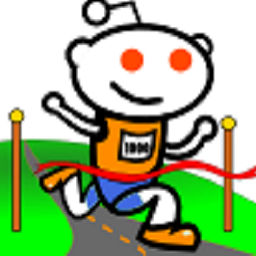
</div>

r/Ultramarathons: "Any idiot can run a marathon. It takes a special kind of idiot to run an ultramarathon."

r/ultrarunning: "Sometimes a marathon isn't far enough"



## Problem statement

I am a newbie to the marathon scene, having completed my first StanChart marathon virtually when the country was locked down during Covid-19 last year. I am itching to do my first ultramarathon (defined as any run beyond 42.195km) and have prepared a series of posts to ask running veterans for training advice. I found two of the most popular reddit communities for the ultra-running community to be r/Ultramarathon and r/ultrarunning. These are some of their attributes:

|subreddit|Date Created|Number of Members|Members Online (at time of checking)|
|---------|------------|-----------------|------------------------------------|
|r\Ultramarathon|Apr 25, 2010|57,000|18 (on 25 Sep, 1500h, SG time)|
|r\ultrarunning|Feb 4, 2012|45,700|40 (on 25 Sep, 1500h, SG time)|

Both communities look quite similar in size. r\Ultramarathon has 25% more members than r\ultrarunning, but the latter has more than twice the number of online (active) members than the former when I checked in at 3pm on 25 Sep. I want to find out where my posts would naturally belong to and elicit the most helpful comments. Their community descriptions are not helpful:
- r/Ultramarathon: Ultramarathon training, race reports, tips, tricks and overall discussion for crazy people who like ultrarunning.
- r/AdvancedRunning: Welcome to ultrarunning.

A quick scan of their recent posts is also not very helpful. Both communities have a lot of posts about how to train for 50k and beyond, as well as other miscellaneous items such as race reports. It is time to deploy my data science skills to come up with an algorithm to decide which running community most suited for my questions...

## Executive summary

Describe both subreddits, e.g. # of users, activity frequency

## Import Libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns

# Import time- and API- related libraries
import time, requests
from datetime import datetime

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

# Import pre-processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import re
# from wordcloud import WordCloud ## Can't seem to install wordcloud, remember to try again at end of project
# from PIL import Image

# Import vectorizing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import modelling-related libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# Set viewing parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Scrap reddit

### Create scrapper function

In [2]:
# Create scrapper function

def scrape_subreddit(subreddit, numberofposts = 1_000):
    # Define pushshift's base URL
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Define columns i want to keep
    to_keep = ['subreddit','author','title','selftext','created_utc']
    
    # Set current time in UTC timestamp format
    df_time = int(datetime.timestamp(datetime.utcnow()))
    
    # Create empty dataframe for concating loop later on
    df = pd.DataFrame(columns = to_keep)
    df_length = len(df)
    
    # Create dataframe of posts
    while df_length < numberofposts:

        # Set params
        params = {
            'subreddit' : subreddit,
            'size' : 100,
            'before' : df_time
        }

        # Get request from pushshift.io, return error message if it is not from 200 series
#         res = requests.get(url, params)
        try:
            res = requests.get(url, params)

            # Return error message if it's not 2xx
            if (res.status_code // 100) != 2:
                return "Hey dude, error! Unexpected response {}".format(res)

        except res.exceptions.RequestException as e:
            # A serious problem happened, like an SSLError or InvalidURL
            return "Yo, this is a very terrible error: {}".format(e)
        
        
        # Concat relevant .json data into dataframe
        df = pd.concat([
            df,
            pd.DataFrame(res.json()['data'])[to_keep]
        ], 
            axis = 0
        )
        
        # Clean data
        ##  1. drop empty posts
        df = df.loc[
            ((df['selftext'] != '') & (df['selftext'] != '[removed]')),
            :
        ].sort_values('created_utc', ascending = False)
        ##  2. drop duplicates by author with same text
        df = df.drop_duplicates(subset=['selftext', 'author'], keep = 'first').reset_index(drop=True)
        ##  3. drop nulls, especially true for selftext column
        df.dropna(inplace = True)
        
        # Find earliest-dated post in dataframe
        df_time = df['created_utc'].min()
#         print(f"min time is {df_time}.")
        
        # Find current length of dataframe (
        df_length = len(df)
        print(f"df for r\\{subreddit} has {df_length} posts now.")
       
        # Be a good citizen of scrapping world, don't overload pushshift server 
        # Sleep between 1-3 seconds
        time.sleep(1 + np.random.rand() * 2)
        
    return df[:numberofposts]
    
    

Describe scrapper function:
- Arguments to feed in are (subreddit, numberofposts)
    - "subreddit" is the name of the target subreddit
    - "numberofposts" is the number of good-quality reddit posts to extract (default value is set at 1_000)
- Set size at 100 for each request for posts
- Dropping bad-quality posts:
    - I notice about 20% of the posts are pictures or videos of people running, with nothing written, i.e. '' in the 'selftext', so those are dropped
    - There are a small number of np.nan posts, those are removed
    - A number of posts seem to be advertisements, they are labeled "[removed]" in the 'selftext' columns, so those are dropped
    - I remove reposts by the same author just in case they are posted more than once
- I set a random sleep time of between 1 to 2 seconds to avoid getting blacklisted by server for repeat requests

### Scrap scrap scrap

> Do not run this section to save time. Jump straight to Section 5.1 to download saved .csv files. Typically takes about 3-10 minutes for me to run, depending on internet connection

To extract 1,500 good-quality posts from each subreddit community. Chosen subreddits are:
- r\Ultramarathon
- r\AdvancedRunning

In [3]:
%%time

# set scrape parameters
subreddit1 = 'Ultramarathon'
subreddit2 = 'ultrarunning'
posts = 1_500


# Do not run this section to save time
# Typically takes about 3-10 minutes for me to run, depending on internet connection
# df1 = scrape_subreddit(subreddit1, posts)
# df2 = scrape_subreddit(subreddit2, posts)

# Load the files below to save time
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

df for r\Ultramarathon has 74 posts now.
df for r\Ultramarathon has 149 posts now.
df for r\Ultramarathon has 220 posts now.
df for r\Ultramarathon has 288 posts now.
df for r\Ultramarathon has 359 posts now.
df for r\Ultramarathon has 435 posts now.
df for r\Ultramarathon has 507 posts now.
df for r\Ultramarathon has 585 posts now.
df for r\Ultramarathon has 665 posts now.
df for r\Ultramarathon has 724 posts now.
df for r\Ultramarathon has 790 posts now.
df for r\Ultramarathon has 854 posts now.
df for r\Ultramarathon has 928 posts now.
df for r\Ultramarathon has 1000 posts now.
df for r\Ultramarathon has 1067 posts now.
df for r\Ultramarathon has 1138 posts now.
df for r\Ultramarathon has 1213 posts now.
df for r\Ultramarathon has 1282 posts now.
df for r\Ultramarathon has 1352 posts now.
df for r\Ultramarathon has 1415 posts now.
df for r\Ultramarathon has 1467 posts now.
df for r\Ultramarathon has 1521 posts now.
df for r\ultrarunning has 79 posts now.
df for r\ultrarunning has 15

In [4]:
df1

,subreddit,author,title,selftext,created_utc
0,Ultramarathon,FlyingSquirrel225,Training Plan/Ankle Injury,Hi! Long-time reader first-time poster (and tr...,1632677925
1,Ultramarathon,1MillionBillsBy30,Race Report Run Rabbit Run 100. From flat 50k ...,Last week I completed my first 100 mile race. ...,1632665258
2,Ultramarathon,Freshlystallone,Dealing With Failure..,"Hey guys,\n\n I'm not sure this belongs here a...",1632650255
3,Ultramarathon,tizawer,MCM 50k Sale,Purchased registration for the Marine Corps Ma...,1632537589
4,Ultramarathon,lazysl0b,What’s your baseline MPW and schedule?,I’ve done a couple of ultras now and want to b...,1632472993
...,...,...,...,...,...
1495,Ultramarathon,[deleted],Considering doing an Ultramarathon.,"I've only ever done one ""endurance"" race: Iron...",1481909965
1496,Ultramarathon,UltraRunningKid,Ultra-Marathon Monday: What are your 2016 Acco...,"Trying out a new thread idea, hoping to see if...",1481562451
1497,Ultramarathon,eflowb,Big races other than WSER and Hardrock,As someone who just started running ultra's la...,1481312190
1498,Ultramarathon,kmjuniormint5,(Ultra)Running Media that I have gathered over...,Let's do this thing! Round 3 of videos from 20...,1481238619


In [5]:
df2

,subreddit,author,title,selftext,created_utc
0,ultrarunning,typetwo_fun,"Trip Report: Killarney, Canada - La Cloche Tra...",&amp;#x200B;\n\nhttps://preview.redd.it/j9xs4h...,1632676882
1,ultrarunning,FlyingSquirrel225,Training Plan Question,Hi - hope this is not too specific of a questi...,1632676824
2,ultrarunning,uYarnOver,Best foods for ultra adventures?,Would anyone share what types of food you brin...,1632672107
3,ultrarunning,Freshlystallone,Failed at 100km..Feel terrible.,"Hey guys,\n\n I'm not sure this belongs here a...",1632649597
4,ultrarunning,4EverPizza,SOCAL RUNNERS,Cucamonga Peak via ice house canyons\n\nStrenu...,1632621087
...,...,...,...,...,...
1495,ultrarunning,TylerCAndrews,"""The Witching Hour"" - Throwback Race Report fr...","Hey everyone! With so few races around, our gr...",1597811150
1496,ultrarunning,Notarunnerbod77,Snotty running forum,Hi. First ever post here. I joined a local run...,1597804154
1497,ultrarunning,VinnyRuns,Full gps of Laurel Highlands,Hey does anyone have a full gps (in any format...,1597756988
1498,ultrarunning,Rossatti97,Questionnaire regarding nutrition in ultra trail,"Hi there runners! \nSo, a dear friend of mine...",1597691104


### Save files to .csv

In [6]:
# Check for nan
print(f"# of Nulls for df1 \n {df1.isnull().sum()}")
print(f"# of Nulls for df2 \n {df2.isnull().sum()}")

# of Nulls for df1 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64
# of Nulls for df2 
 subreddit      0
author         0
title          0
selftext       0
created_utc    0
dtype: int64


In [7]:
# Check files that have empty posts or that are '[removed]' by reddit

In [8]:
df1.loc[((df1.selftext == '[removed]') | (df1.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [9]:
df2.loc[((df1.selftext == '[removed]') | (df2.selftext == '')), :]

,subreddit,author,title,selftext,created_utc


In [10]:
# Check for reposts
df1.duplicated().sum(), df2.duplicated().sum()

(0, 0)

In [11]:
# Save files
df1.to_csv('../data/df1.csv', index = False)
df2.to_csv('../data/df2.csv', index = False)

## EDA and pre-processing

### Load data

In [12]:
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

In [13]:
df1.shape, df2.shape

((1500, 5), (1500, 5))

### Check authors
The intent is to look for very prolific authors who might post so much to a subreddit community that a classification model might just innocently fit to a very small group of authors' writing style. 

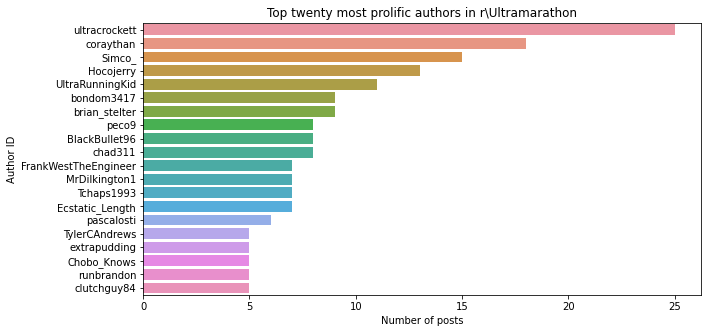

In [14]:
# Rank authors by posts
authors = df1.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit1}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

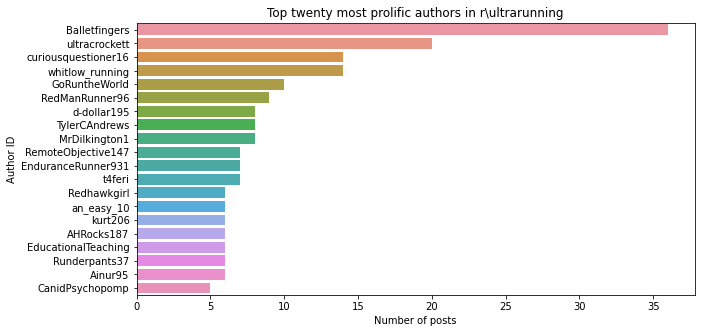

In [15]:
authors = df2.groupby("author")['selftext'].count().sort_values(ascending = False).head(20)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = authors.values, y = authors.index)
ax.set_title(f"Top twenty most prolific authors in r\\{subreddit2}")
ax.set_xlabel("Number of posts")
ax.set_ylabel("Author ID");

It looks like there is no issue with overly-prolific authors on both subreddits. The author with the highest number of posts on r\Ultramarathon is ultracrockett with 25 posts and the author with the highest on r\ultrarunning is Balletfingers with 36 posts. They make up <=3% of their sample sets respectively. 

* However, I notice that ultracrockett is the second largest contributor on r\ultrarunning. This might pose a bit of problem during the modeling stage, as his posts might cause high correlation between the two subreddits. As a robustness check, I will remove his posts at the end of the project to see if its makes a material difference in predictive accuracy.

In [16]:
# Check posts written by AutoModerator
# pd.set_option('display.max_colwidth', None) #Expand Pandas' column width to show full thread content 
# df2[df2['author'] == "AutoModerator"]

[Only relevant if i pick r\\AdvanceRunning]: It looks like 'AutoModerator' is a bot that automatically generates posts to keep readers interested or engaged on events happening in the running world. I shall drop its posts since we are interested in analysing human-generated posts only. These posts make up <0.5% of the sample set.

In [17]:
# # Drop AutoModerator
# df1 = df1[df1['author'] != "AutoModerator"]
# df2 = df2[df2['author'] != "AutoModerator"]

In [18]:
# # Check
# df1[df1['author'] == "AutoModerator"], df2[df2['author'] == "AutoModerator"]

### Check dates

In [19]:
# Check time range of df1
print(f"The start date of df1 is {datetime.fromtimestamp(df1.created_utc.min())}.")
print(f"The end date of df1 is {datetime.fromtimestamp(df1.created_utc.max())}.")

The start date of df1 is 2016-12-06 08:34:59.
The end date of df1 is 2021-09-27 01:38:45.


In [20]:
# Check time range of df2
print(f"The start date of df2 is {datetime.fromtimestamp(df2.created_utc.min())}.")
print(f"The end date of df2 is {datetime.fromtimestamp(df2.created_utc.max())}.")

The start date of df2 is 2020-08-17 12:40:25.
The end date of df2 is 2021-09-27 01:21:22.


r\Ultramarathon has a wider date range than r\ultrarunning. Let's check the distribution of their post dates.

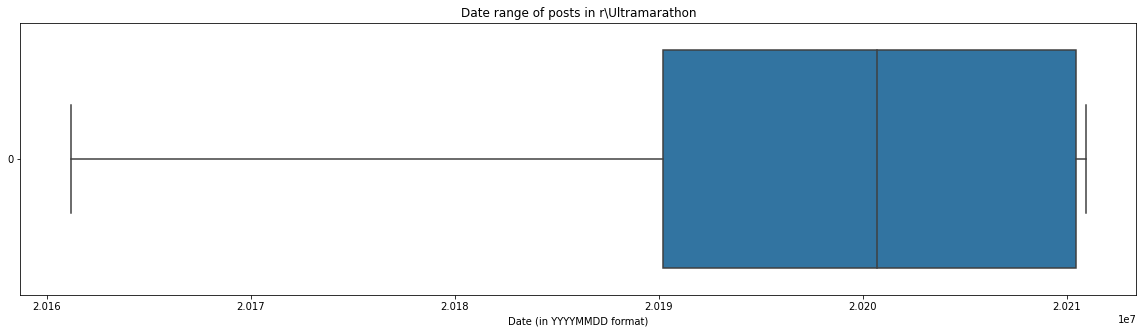

In [21]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df1.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit1}")
ax.set_xlabel("Date (in YYYYMMDD format)");

While r\Ultramarathon has a 5 year date range for its posts, most of them are concentrated in the 2019-2021 range, so they are still quite recent. The 2019-2021 posts are also quite uniformly distributed around the median post. 

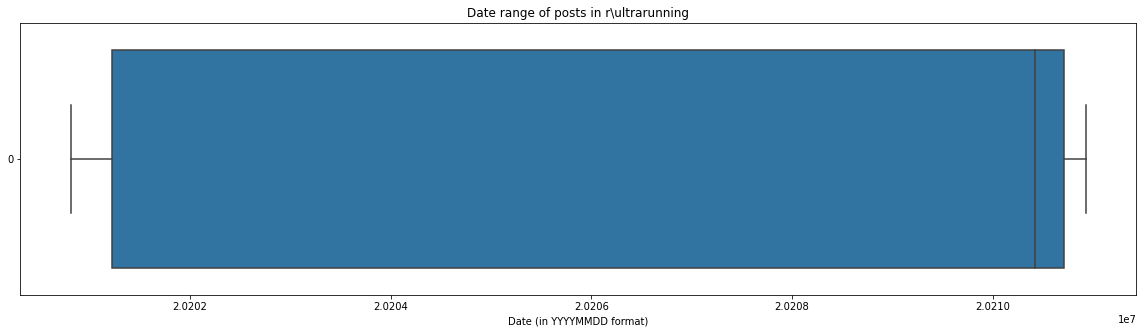

In [22]:
# Convert UTC time to yyyymmdd format, and plot date range
plt.figure(figsize = (20,5))

ax = sns.boxplot(
    data= [int(datetime.utcfromtimestamp(x).strftime("%Y%m%d")) for x in df2.created_utc],
    orient = "h",
)

ax.set_title(f"Date range of posts in r\\{subreddit2}")
ax.set_xlabel("Date (in YYYYMMDD format)");

No surprises here, as all of r\ultrarunning's posts are in 2020 and 2021. The only insight here is that this community is quite active recently, with the median post tilted to 2021.

r\ultrarunning clearly seems to be a more popular or active subreddit. However, less active does not mean worse, as the quality of posts may be more important. We shall move on to check on post length characteristics.

### Check low word count posts

In [23]:
df = pd.concat([df1, df2], axis = 0).reset_index(drop=True)
df['word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [24]:
df.groupby('subreddit').agg({'word_count': ['min', 'median', 'mean', 'max']})

word_count                      
                     min median     mean   max
subreddit                                     
Ultramarathon          1   90.0  156.382  3720
ultrarunning           1   93.0  140.244  2663

The median post in r\Ultramarathon is slightly shorter than r\ultrarunning, but the mean word count is higher, so it suggests that some writers in the latter community write very long posts, perhaps ultracrockett!

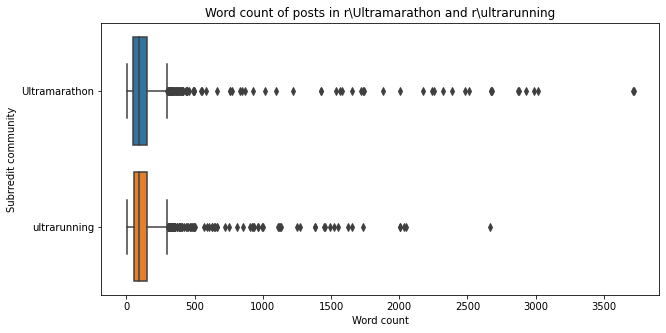

In [25]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "word_count", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

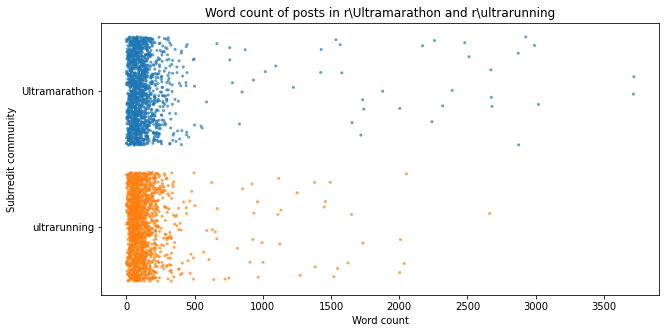

In [26]:
plt.figure(figsize = (10,5))
ax = sns.stripplot(data = df,
                   x = "word_count", 
                   y = "subreddit",
                   size = 3,
                   alpha = 0.7,
                   jitter = 0.4
                   
                
);

ax.set_title(f"Word count of posts in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Word count");
ax.set_ylabel("Subrredit community");

Box plots and strip plots suggest that writers in r\Ultramarathon write more than those in r\ultrarunning, with quite a number of them writing essay-length posts of over 2000 words!!
However, I do not see big material differences between the two communities of runners that will pose an obstacle to my problem statement.

In the groupby table above, I notice that the minimum number of words is 1. Let's analyse posts with low word counts to see if they are useful for my model. I start with a random sample of posts with 5 words or less.

In [27]:
# Count the number of posts with low word count
for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 15 posts of word count length = 1.
There are 4 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 5 posts of word count length = 4.
There are 10 posts of word count length = 5.


In [28]:
# Increase column width to view post contents
pd.set_option('display.max_colwidth', None)

In [29]:
# Sample posts with low word counts to see if they are useful
df.loc[df['word_count'] <= 5, :].sample(5)

,subreddit,author,title,selftext,created_utc,word_count
676,Ultramarathon,cbskiddies,Does anyone know a 100 miler single loop or point to point going on west of Kansas in November or December?,Looking for recommendations!,1602532095,3
634,Ultramarathon,PooQuiche,"Hayden Hawks at the JFK50, bloody 'ell! Strava link below...",[https://www.strava.com/activities/4371169723](https://www.strava.com/activities/4371169723),1605989619,1
1333,Ultramarathon,Dantoo2008,Peter Attila,How to achieve UM?,1520300400,4
1206,Ultramarathon,clutchguy84,"Race report from Indiana Trail, 2018",[https://clutchrunner.blogspot.com/2018/10/no-pacer-no-problem-indiana-trail-100.html](https://clutchrunner.blogspot.com/2018/10/no-pacer-no-problem-indiana-trail-100.html),1539621099,1
509,Ultramarathon,King_falcon-113,Wyrr,Chose\n\n[View Poll](https://www.reddit.com/poll/lfmgsu),1612819981,3


It looks like vast majority of low word count posts are urls. Some are obvious spams, such as "love stream is at:..." These will be handled at the pre-processing stage.
Some are post of run timings, which may be relevant or useful information to readers and will be kept.

### Total word count
<a id='word_count_1'></a>

In [30]:
# Count starting number of words
print(f"Before pre-processing, I start with {df['word_count'].sum()} words in my dataset.")

Before pre-processing, I start with 444939 words in my dataset.


### Remove URLs

In [31]:
# Remove all text with "http" in it
df['cleaned_1'] = df['selftext'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

In [32]:
# Sample to check rows with URLs orginally
df.loc[['http' in x for x in df['selftext']],['selftext','cleaned_1']].sample(2)

,selftext,cleaned_1
660,"Hey guys, just wondering if you can fill out this short and anonymous survey/form about your preferences when running. It takes no more than 2 minutes to complete and the data will be used to work on a cool project that benefits you all :)\n\n[https://forms.gle/aV3yD9hBVVx4neAM6](https://forms.gle/aV3yD9hBVVx4neAM6)","Hey guys, just wondering if you can fill out this short and anonymous survey/form about your preferences when running. It takes no more than 2 minutes to complete and the data will be used to work on a cool project that benefits you all :)\n\n["
2384,Sorry it's in miles\n\n[View Poll](https://www.reddit.com/poll/lwjp9c),Sorry it's in miles\n\n[View Poll](


In [33]:
# Refresh word count column
#   and check posts with low word count again
df['word_count'] = df['cleaned_1'].map(lambda x: len(x.split()))

for i in range(1,6):
    print(f"There are {len(df[df['word_count'] == i])} posts of word count length = {i}.")

There are 11 posts of word count length = 1.
There are 2 posts of word count length = 2.
There are 3 posts of word count length = 3.
There are 8 posts of word count length = 4.
There are 7 posts of word count length = 5.


### Check low word count posts again

There are just a handful of posts with 2 words or less. These might be the remnants of those posts that mainly most links to videos or other websites. Let's check them out.

In [34]:
# Sample posts with 2 word counts or less
df.loc[df['word_count'] <= 2, ['author','title','cleaned_1']]

,author,title,cleaned_1
222,mcdishy,Sabrina Verjee smashes Wainright round record!,
300,edgar_allen_snatch69,How many miles per week should you average in order to run a race that is 100+ miles?,\n\n[View Poll](
482,[deleted],Sleepiness,[deleted]
556,ExerciseThoughtStudy,We are a group of researchers at Rutgers University who are conducting a research study about thoughts and emotions during exercise. See the flyer for more information and to take our prescreen survey.,[\n\n
601,EubieDubieBlake,Desert Solstice is live on Youtube right now,
634,PooQuiche,"Hayden Hawks at the JFK50, bloody 'ell! Strava link below...",[
1206,clutchguy84,"Race report from Indiana Trail, 2018",[
1247,ThinkingTooHardAbouT,Ultrarunning in a nutshell: Two years ago during a 40M race I got stung eight times in the head by hornets and won. This year I got stung in the crotch. PB.,#beetoo
1297,tararunstheworld,Transylvania 50k Ultra was intense. I would recommend it for those that like pain.,[
1514,MuiMui888,Banning Vitamin I in UTMB. Seems a bit overreaching,


To delete all of the above posts, they are not written in proper English and won't contribute in training my model in predicting posts.

In [35]:
# Delete cleaned posts with 2 words or less
df = df.loc[df['word_count'] >2,:]
# Check
df.shape

(2981, 7)

In [36]:
# Check posts with 3 words
df.loc[df['word_count'] == 3, ['author','title','cleaned_1']]

,author,title,cleaned_1
509,King_falcon-113,Wyrr,Chose\n\n[View Poll](
676,cbskiddies,Does anyone know a 100 miler single loop or point to point going on west of Kansas in November or December?,Looking for recommendations!
689,SGF2YT,Ksjjs,Die die dieee


In [37]:
# Check posts with 4 words
df.loc[df['word_count'] == 4, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
209,Ultramarathon,mcdishy,The UK’s Top 10 Ultramarathons,In one guys opinion! \n\n
508,Ultramarathon,King_falcon-113,Would you rather,Ok thx\n\n[View Poll](
813,Ultramarathon,Ultramarathoner,2020 Barkley Marathons Cancelled,Jamil Coury announced it.
896,Ultramarathon,bigtasty2019,What you pack (food/prep/first aid) for a 50K,Show me your goodies
1333,Ultramarathon,Dantoo2008,Peter Attila,How to achieve UM?
1446,Ultramarathon,Johnnytheknife,"For anyone interested, Comrades marathon starts in less than two hours...",Love stream is at:
1953,ultrarunning,mcdishy,The Top 10 UK Ultra’s,In one guys opinion! \n\n
2163,ultrarunning,MountainRunner911,Thoughts on ultrarunners using cannabis for recovery or just in general during training blocks?,Just curious about this.


In [38]:
# Check posts with 5 words
df.loc[df['word_count'] == 5, ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
559,Ultramarathon,MrDilkington1,"So how many 50's, 100k's and 75/80 mers did you do before running 100 miles?",Just trying to build perspective
764,Ultramarathon,optimisticpessimist5,What are some good 50 miles this year that have not been cancelled?,If there are any left.
977,Ultramarathon,05778,Why Not Kill This Subreddit?,And merge it with r/ultrarunning?
1080,Ultramarathon,Rogue_Artichoke,How do you all stretch daily?,Asking for a friend. :)
1308,Ultramarathon,ElHalcon,"My Aldi is featuring a Crane brand ultra-type hydration vest next week. Bladder not included, but...",[Hydration type vest at Aldi.](
2442,ultrarunning,adriannairda,Is someone here doing the 4-4-48 challenge?,Any recommendations? Much appreciate it!
2907,ultrarunning,exiveres,Racing?,Are any states allowing ultras?


After deleting posts with 2 or less words, I analyse posts with 3-5 words. 

It is clear that the longer the posts, the more relevant they are to running:
* Those with 3 words are irrelevant and will be killed off.
* Those with 4 words are less relevant so it should be okay killing it. For example, one has a message called "love stream is at:" while another author named mcdishy posted the same message on both subreddits giving his opinion of the top 10 ultramarathons in the UK.
* The posts with 5 words are somewhat relevant to running, so I shall keep them. Including one asking for r/Ultramarathon to be killed or merged with r/ultrarunning! Looks like I am not the only one feeling frustrated by two similar subreddit communities!!


In [39]:
# Remove posts with 3 and 4 words, retain only posts with 5 words and above

df = df.loc[df['word_count'] >= 5,:].reset_index(drop=True)
# Check
df.shape

(2970, 7)

A total of 30 mostly-irrelevant posts (== 1% of the original posts) are removed.

### Remove special characters

In [40]:
# Look at cleaned samples again
df[['subreddit','title','cleaned_1']].sample(5)

,subreddit,title,cleaned_1
1762,ultrarunning,How to add a short race training cycle between long races training cycles?,"Since a few years my training is focused around long trail races (from 50km to &gt;100km)\n\nI have just completed a 6 months training cycle concluded by a 100km 6000m elevation race. \n\nMy training is focused on mileage (roughly &gt;95km per week the last 3 months before a race) at low-ish intensity and elevation (as part of my runs + hill repeats). So no speed work or tempo runs.\n\n&amp;#x200B;\n\nI am considering joining a short trail race (1/2 marathon, 200m elevation) during the autumn.\n\nSo it will be a training cycle of 3 months for a shorter distance between training cycles for longer distances. \n\nI'm a bit uncertain how to attack this and have been struggling to find some info regarding this specific case:\n\n\- Is it best to follow a training plan for a 1/2 marathon?\n\n\- Or should I maintain my current approach (low intensity mileage), maybe reduce the distance per week and add one or 2 specific sessions per week, and in this case what kind of work is the most efficient for a 1/2 marathon (tempo run, fast intervals, long intervals...)?\n\nThanks for the inputs!"
1913,ultrarunning,Sun Hoody or Minimal Clothes?,Running a 50miler in the mountains with significant sun exposure in mid July. Likely quite warm in the afternoon. I’ve had some friends tell me they swear by a sun shirt such as thin Patagonia capilene hoody but some swear by minimal clothes/tank top. Any thoughts on a preference? I like the idea of blocking UV rays but am worried the hoody will be too warm.
2473,ultrarunning,Altitude's effect on aerobic threshold,"I've been running for years but just recently got into reading Training for the Uphill Athlete and it's blowing my mind. \n\nNow instead of doing most of my runs in zones 3 and 4 I'm pulling it wayyyy back and trying to stay at or under my first aerobic threshold. For lack of a better way to test, I just try to breath through my nose when I run and that puts me right at around 145-150 bpm. \n\nThis all seems well and good but it feels kind of high. I just moved from sea level to Colorado so I'm wondering if anyone has any experience with how altitude effects this? The examples in the book put the AeT for people just starting this kind of training way lower like 130 to 135. \n\nI'm at around 8 min/mile at my LT which is around 160 bpm I think. But now am struggling to do even 12 minute miles without my heart rate shooting up to 155, which is where breathing through my nose is no longer an option for me. \n\nAlso, it's super cold here and kind of hurts to breath through my nose? Am I just going too hard? \n\nThanks in advance."
1554,ultrarunning,Is there a low/zero drop shoe with a rock plate?,Other than Altra \n\nMy ideal shoe would be Inov-8 TUG 270 with a rock plate
1240,Ultramarathon,"I have 9 weeks to get ready, including today. Linked is my training plan, feedback welcome.","So, I signed up for my first 50k. I was following a plan but ran into a problem with my longer runs. I was having problems recovering on the longer runs so I made a plan with similar mileage to other 50k training plans with more moderate runs. I am hoping this will build the conditioning I need, with less recovery time needed. I heard a podcast recently about the merits of going at 70% most of the time and training everyday versus going to failure or just before and having to recover before training again. Any feedback is welcome as I am totally new to this. My background is that I was not much of a runner before this, I have been running about 15-25 miles a week up until this point and my long run was 10 miles. That one took me 2.5 days before I could run again. I am also super wary of injury so I am taking it slower than normal as an injury this close basically means I just have to cancel the race. Also, I am fine with 13-15 min mile pacing. I just want to finish. Here is the link to the plan I drew

Ran through a number of samples. Manually remove "\n", "\\" , "[]", "()", "|", "-", "&amp;#x200B". Because these subreddits are running-related, it is probably not a good idea to remove numbers as they are usually related to distances or timings. I will probably submitting numbers in my own posts to the subreddits too!

I also notice a lot of "ultras" and "ultramarathons" mentioned on both subreddits, so mental reminder to myself to include them as stop words.

In [41]:
# Replace specials characters
# df['cleaned_2'] = df['cleaned_1'].map(
#     lambda x: re.sub(r'[\n\\\[\]\(\)\|\-]', ' ', x)
# )

# Remove the %ampersand term
df['cleaned_2'] = df['cleaned_1'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['cleaned_2'] = df['cleaned_2'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)


In [42]:
# Check for removal of special characters
df[['cleaned_1','cleaned_2']].sample(5)

,cleaned_1,cleaned_2
2021,"Are there any gaiters that utilize Altra's gaiter trap, but are more durable? It's OK if they weigh more, but they should last. I do not like holes in my almost new gaiters.",Are there any gaiters that utilize Altra s gaiter trap but are more durable It s OK if they weigh more but they should last I do not like holes in my almost new gaiters
1774,"Hello guys,\n\nI am a software engineer who started to run recently. While I was doing my research about running I found out that I should track heart zones during workouts.\n\nI searched for heart zones watchOS tracking apps, tried some, but none of them seemed to suit me well. My requirements were mainly:\n\n* Track heart zone with other workout metrics (distance, bpm, pace, time) in same screen without scrolling, just with glance at my watch.\n* Device beeps (vibrations) when passing through zones.\n* Support of continuous alert when leaving target zone. Stop beeping when entered target zone again.\n\nAs a bonus, few times I wanted to know when sunset occurs as I didn't know if I could take extended route and make it home until sunset. Like some sort of sun pictogram with minutes left, showing 45 mins before sunset.\n\nSo I decided to create a watchOS app for myself that will satisfy my needs, which I mentioned earlier. Currently I have working prototype, that I am beta testing by myself. I am planning to add new features, companion iOS app with settings etc.\n\nWhat is your opinion about the app? Would you use it? What workout app for watchOS do you use now? What features do you miss on those apps?\n\nAlso if you are software engineer/designer/product manager and would like to collaborate with me on the app feel free to contact me directly.",Hello guys I am a software engineer who started to run recently While I was doing my research about running I found out that I should track heart zones during workouts I searched for heart zones watchOS tracking apps tried some but none of them seemed to suit me well My requirements were mainly Track heart zone with other workout metrics distance bpm pace time in same screen without scrolling just with glance at my watch Device beeps vibrations when passing through zones Support of continuous alert when leaving target zone Stop beeping when entered target zone again As a bonus few times I wanted to know when sunset occurs as I didn t know if I could take extended route and make it home until sunset Like some sort of sun pictogram with minutes left showing mins before sunset So I decided to create a watchOS app for myself that will satisfy my needs which I mentioned earlier Currently I have working prototype that I am beta testing by myself I am planning to add new features companion iOS app with settings etc What is your opinion about the app Would you use it What workout app for watchOS do you use now What features do you miss on those apps Also if you are software engineer designer product manager and would like to collaborate with me on the app feel free to contact me directly
2732,"Hello.\n\nI am running my first Ultra tomorrow. Its not being ran as a group due to covid restrictions, we are all running the same trail but can start whenever and just keep timing ourselves.\n\nIts a 45km trail consisting of a 16km loops with 3km out and back to start/finish area. The big one is it has 2500m elevation and some parts will have light snow cover.\n\nI am just looking for some tips and advice on timing and other things that I may not have thought of.\n\n**Myself:\n**\nRunning about 6 months, no real background before. \n\nLongest run 6:09:21\t36.53 km\t1,885 m\t(I could gave done more flat running but was 100% walking the uphills)\n\nLast long run 3:57:28\t28.92 km\t1,200 m (Very comfortable could have done a lot more, power hiking the uphills and running downhills whole time)\n\nBoth of these were in similar conditions to the race. \n\nQuestions.\n\n1. How long should I plan for the race ? Im thinking 8 hours should be

A few rounds of sampling shows that the cleaning looks fine.

### Check sentiment

I am curious to find out the general sentiment of writers in these two subreddits, want to see if there is a discernible difference between each community. I use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiments of our posts.

In [43]:
# Create sentiment column
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_2'].map(lambda x: sent.polarity_scores(x)['compound'])

In [44]:
# Check sentiment
df.groupby('subreddit').agg({'sentiment': ['min', 'median', 'mean', 'max']})

sentiment                          
                    min  median      mean     max
subreddit                                        
Ultramarathon   -0.9979  0.6887  0.494464  0.9999
ultrarunning    -0.9969  0.6908  0.458568  0.9997

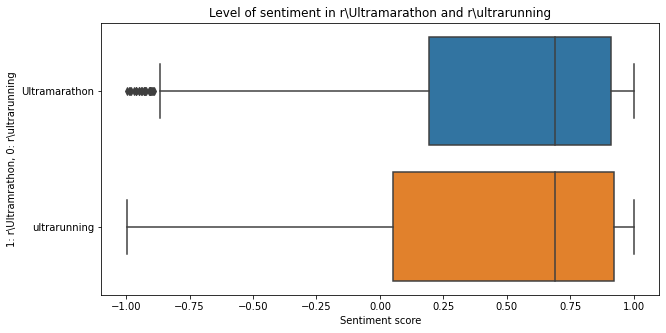

In [45]:
plt.figure(figsize = (10,5))
ax = sns.boxplot(data = df, 
                 x = "sentiment", 
                 y = "subreddit",
                 orient = "h",
);

ax.set_title(f"Level of sentiment in r\\{subreddit1} and r\\{subreddit2}")
ax.set_xlabel("Sentiment score");
ax.set_ylabel("1: r\\Ultramrathon, 0: r\\ultrarunning");

The median runner-author seems to be a very positive person, with a score of 0.69 for both subreddits. The mean score is much lower for both communities, dragged down by a number of neutral and negative posts. I cannot discern a material difference between posts in the two subreddit communities based on VADER sentiment analysis.

### Tokenize words

I shall make all words lower case and split by blank spaces.

In [46]:
# Tokenizing...
df['cleaned_3'] = df['cleaned_2'].map(lambda x: x.lower().split())
# Check
df[['cleaned_1','cleaned_2','cleaned_3']].sample(5)

,cleaned_1,cleaned_2,cleaned_3
2413,"I live in New England. Typically when winter hits, I cut back on running and focus on snow sports but this year, I decided to go for a 100-miler in early May (it’ll be my second). So in my mileage build-up, I’m spending a lot of time running slowly in 10-20 degree F temps. \n\nCold weather doesn’t bother me except I am thinking about food A LOT during my long runs, which I never do in warmer temps. Today I was dreaming about pancakes almost against my will. I fuel every 45 mins or so but it never feels like enough. And I am starving for the rest of the day, despite eating amply. I’ve actually gained a few pounds (but I usually do in winter anyway).\n\nThis hunger would make sense if I was shivering and freezing for 3 hours, but of course I warm up after 2 miles and feel quite comfortable for the majority of the time. Most of the articles I’ve read seem to confirm that if you’re warm, you’re not burning extra calories just by running in the cold. \n\nTLDR: Does my body actually require more calories from running in the cold? Or is there something mental or psychological at play involving hunger, warmth, and Kodiak cakes?",I live in New England Typically when winter hits I cut back on running and focus on snow sports but this year I decided to go for a miler in early May it ll be my second So in my mileage build up I m spending a lot of time running slowly in degree F temps Cold weather doesn t bother me except I am thinking about food A LOT during my long runs which I never do in warmer temps Today I was dreaming about pancakes almost against my will I fuel every mins or so but it never feels like enough And I am starving for the rest of the day despite eating amply I ve actually gained a few pounds but I usually do in winter anyway This hunger would make sense if I was shivering and freezing for hours but of course I warm up after miles and feel quite comfortable for the majority of the time Most of the articles I ve read seem to confirm that if you re warm you re not burning extra calories just by running in the cold TLDR Does my body actually require more calories from running in the cold Or is there something mental or psychological at play involving hunger warmth and Kodiak cakes,"[i, live, in, new, england, typically, when, winter, hits, i, cut, back, on, running, and, focus, on, snow, sports, but, this, year, i, decided, to, go, for, a, miler, in, early, may, it, ll, be, my, second, so, in, my, mileage, build, up, i, m, spending, a, lot, of, time, running, slowly, in, degree, f, temps, cold, weather, doesn, t, bother, me, except, i, am, thinking, about, food, a, lot, during, my, long, runs, which, i, never, do, in, warmer, temps, today, i, was, dreaming, about, pancakes, almost, against, my, will, i, fuel, every, mins, or, so, but, it, never, ...]"
2680,In the asics plans here: \n\nThe 3:30 and 3:00 marathon plans peak at a measly 35-40mpw. But there are 3-4 speed or hill workouts a week\n\nIs this inferior to just adding miles? Wouldn't 60mpw get you better results?,In the asics plans here The and marathon plans peak at a measly mpw But there are speed or hill workouts a week Is this inferior to just adding miles Wouldn t mpw get you better results,"[in, the, asics, plans, here, the, and, marathon, plans, peak, at, a, measly, mpw, but, there, are, speed, or, hill, workouts, a, week, is, this, inferior, to, just, adding, miles, wouldn, t, mpw, get, you, better, results]"
705,"Summers in GA are aggressively warm... With 12+ hours/week of outdoor training, I go through \~5 28oz bottles of BodyArmor (Orange Mango) weekly. In an attempt to curb my use of plastic, I wanted to potentially test my mixology skills and brew some electrolyte bev at home.\n\nAnyone experimented with this in the past? Any good recipes? Should I just use an electrolyte powder?",Summers in GA are aggressively warm With hours week of outdoor training I go through oz bottles of BodyArmor Orange Mango weekly In an att

In [47]:
# Count total number of words again
np.sum([len(x) for x in df['cleaned_3']])

443587

After cleaning and splitting, I actually end up with more words in total (444,833) than my [initial naive word count](#word_count_1) of 442,751.

### Common words analysis
<a id='common_words'></a>

I shall first look at word frequency and conduct a few iterations of different "stop words".

In [48]:
# Create function to analyse top 20 most frequently used words 
#   with defined stop-words dictionary 
def frequentwords(data, column_name = None, stopwords = None, n = 1):
    cvec = CountVectorizer(
        stop_words = stopwords,   # Default is no stop words
        ngram_range = (n,n)      # Default is to analyze 1-gram only
    )
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector1_df)
    
    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    )
#     print(vector2_df)
    
    # Prepare subplot area
    fig, axes = plt.subplots(figsize = (10,15), nrows = 3, ncols = 1)
    
    # Plot top 20 most common words
    ax1 = sns.barplot(
        x = vector1_df.head(20).values,
        y = vector1_df.head(20).index,
        orient = 'h',
        ax = axes[0]
    )
    ax1.set_title(f"Top 20 most common words for r\\{subreddit1}")
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Words");
    
    ax2 = sns.barplot(
        x = vector2_df.head(20).values,
        y = vector2_df.head(20).index,
        orient = 'h',
        ax = axes[1]
    )
    ax2.set_title(f"Top 20 most common words for r\\{subreddit2}")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Words");
    
    # Plot Venn diagram to check intersection of 50 most common words
    ax3 = venn2(
        [
            set(vector1_df.head(50).index),
            set(vector2_df.head(50).index)
        ],
        set_labels = (f'r\\{subreddit1}', f'r\\{subreddit2}')
    )
    plt.title('Top 50 words in posts')
    plt.tight_layout()

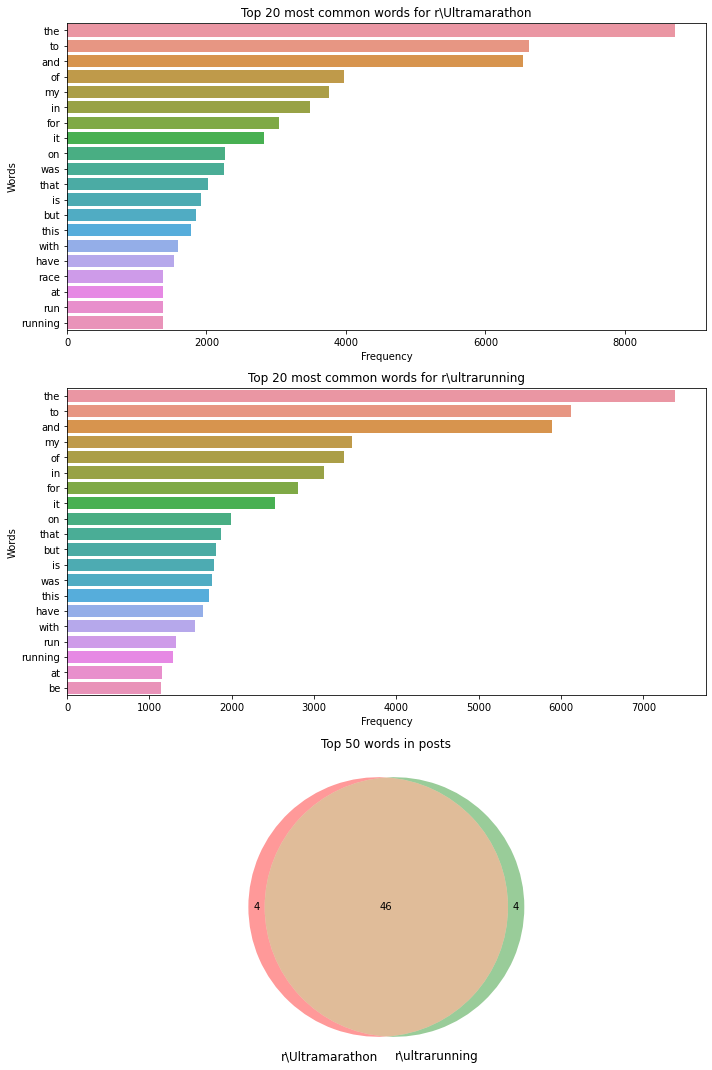

In [49]:
# Check most frequent words for subreddits
frequentwords(df, 'cleaned_2')

Both subreddits have almost exactly the same common words! That doesn't bode well for differentiating between subreddits. I shall apply NLTK's default stop word dictionary and see if anything changes.

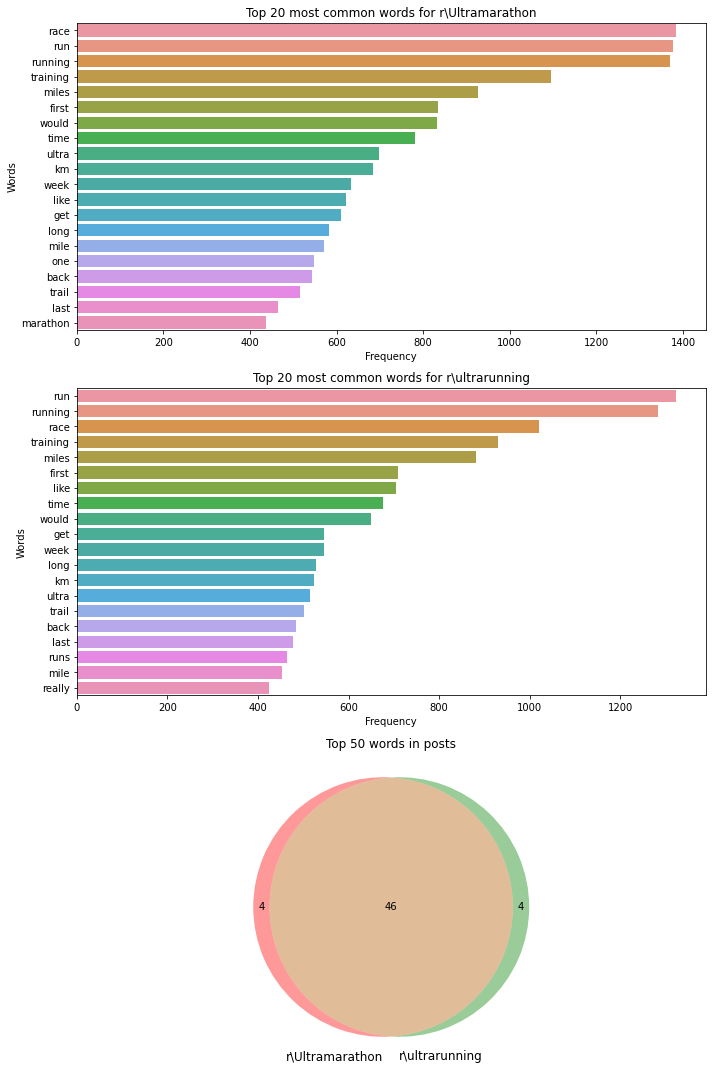

In [50]:
# Apply nltk stop words
words_to_remove = stopwords.words('english')

# Check most frequent words after stop word removal
frequentwords(df, 'cleaned_2', words_to_remove)

Looking better now. Here are some additional words to remove in the next round:
- Remove "ultramarathon", "ultramarathons", "ultrarunning" from both subreddits, to avoid giving the model an unfair advantage since the purpose is to figure out if a post should belong to r\Ultramarathon or r\ultrarunning
- Remove common running words such as "run", "running", "race", "training", "miles", "mile"

In [51]:
# Round 3: Expand stop word dictionary
words_to_remove += ["ultramarathon", "ultramarathons", "ultrarunning"]
words_to_remove += ["run", "running", "race", "training", "miles", "mile"]

In [52]:
# Check last few words in dict
words_to_remove[-20:]

["shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'ultramarathon',
 'ultramarathons',
 'ultrarunning',
 'run',
 'running',
 'race',
 'training',
 'miles',
 'mile']

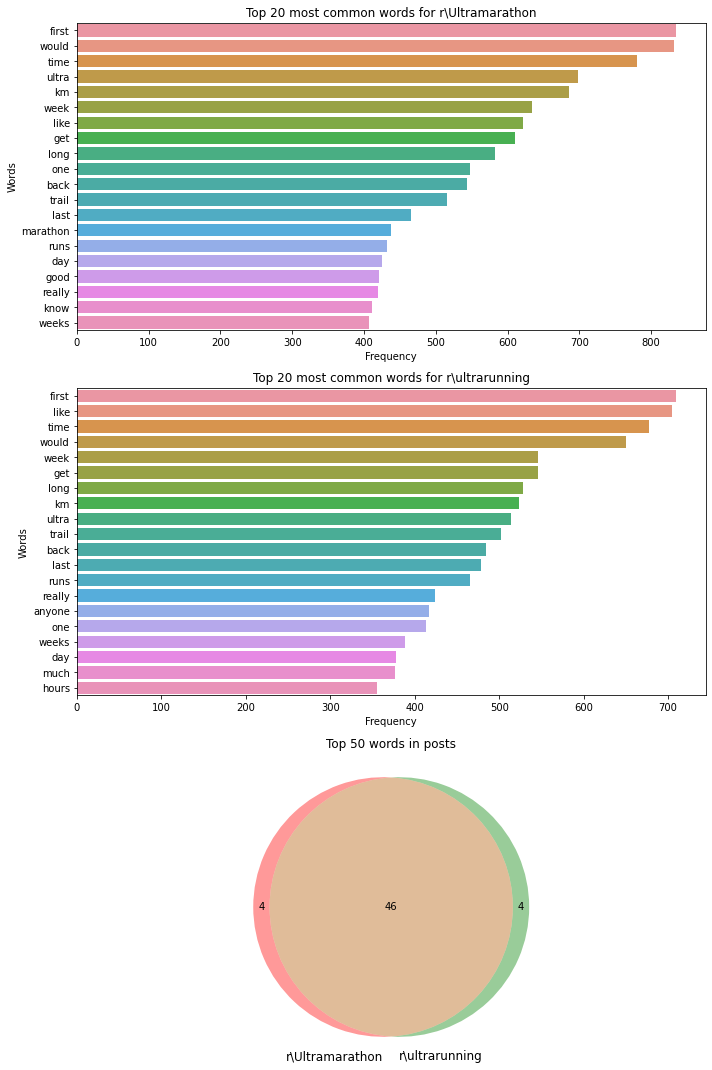

In [53]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove)

The most frequently used words are starting to look a little more different between the two subreddits but still a lot of similarities. It seems like it will be an uphill task for my classification model later. 

However, we cannot just remove all intersected words as they may be constituents of meaningful bigrams or trigrams. Let's take a look at them now.


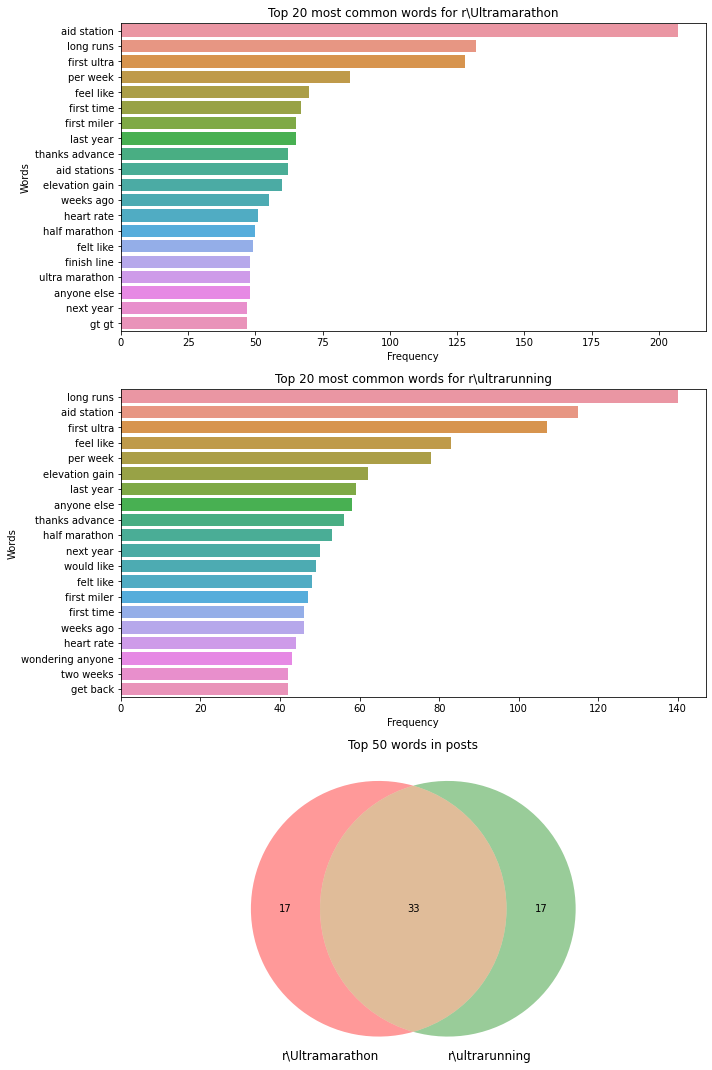

In [54]:
# Analyze bi-grams in subreddits
frequentwords(df, 'cleaned_2', words_to_remove, 2)

Bi-grams for both subreddits are also quite similar. Classificatio model won't be easy to train well...

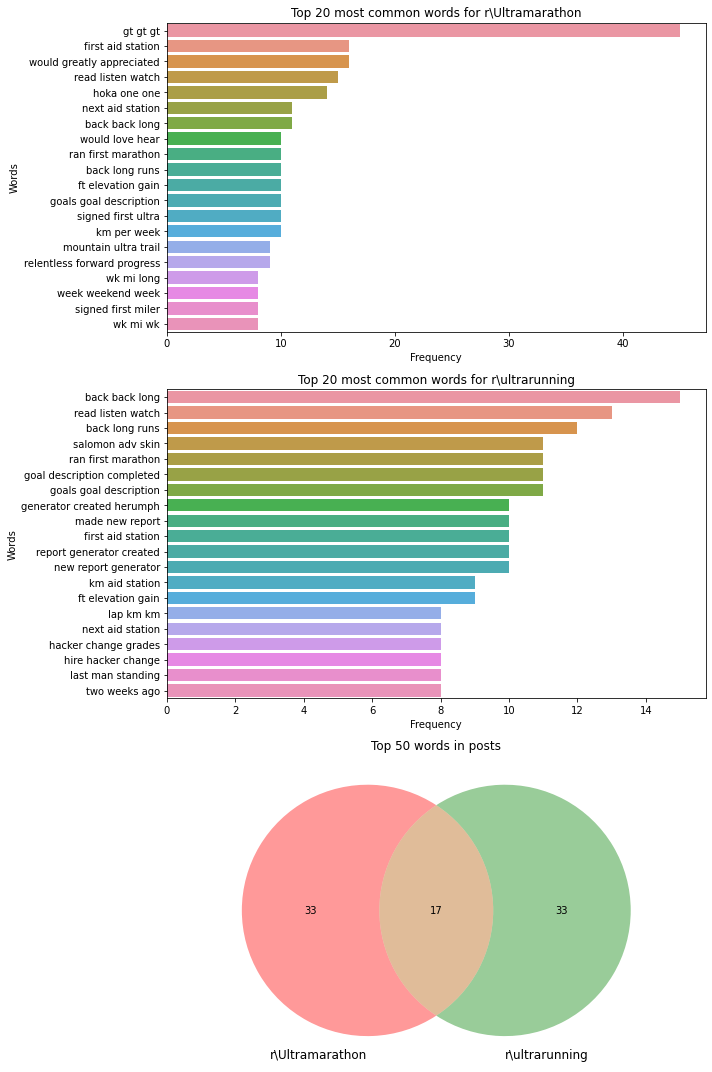

In [55]:
# Analyze tri-grams in subredditsa
frequentwords(df, 'cleaned_2', words_to_remove, 3)

I can see more differentiation in tri-grams coming from the two subreddit communities. That gives a bit of hope for the modeling, as I can run word vectorizers that utilizes bigrams and trigrams.

### Lemmatize and stemmatize

Next step is to lemmatize the word tokens.

In [56]:
# Lemmatize after removing stop words
lemmatizer = WordNetLemmatizer()

df['cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [57]:
# Check
df[['cleaned_2', 'cleaned_lemma']].sample(5)

,cleaned_2,cleaned_lemma
939,About weeks ago I got this crazy idea I would run an ultramarathon I ran a lot when I was in the Army but haven t been an avid runner in about years The last years I have been doing a lot of bike riding racing no pro pretty minor entry level stuff This past winter I ran a few times a month and since April maybe times Otherwise I mostly just rode my bike My previous longest run was last year miles in about hr and min Fast forward to weeks ago I was binge watching Billy Yang Films youtube channel and thought what the heck I ll give it a shot I saw a hr endurance run being held about miles away from me I contacted the organizer asked a few questions and quickly realized this could be a great chance on a beautiful course with a lot of opportunity for aid if needed The course was mi loop on a break wall into a lake An aid station about half way through I figured I could run until I couldn t and worst case walk if I had to Leading up to the race in my head I told myself I could get top When the race started I found myself running closely with others chasing the guy in st I was so excited I thought for sure I would do very well For the first miles I was neck and neck with another guy going for rd place Shortly after I fell apart I walked for a few miles took in fluids and fruit and some gummy bears At mile I ran again for about miles After that I was pretty wrecked but only half way through the hrs I realized I had a giant blister on my left foot and some chaffing on my privates Cheap shoes cotton socks and walmart shorts with no support mistake of my life The rest of my race consisted of people passing me and my doing this awkward run walk situation At hours I was at mi I decided to go for one more lap it didn t count if I didn t complete before the hr time limit Just after starting the last lap I realized it wouldn t happen I finished laps mi in hours The last hours have been quite painful sore muscles blisters and some bad chaffing I m glad I did this race and it may have reignited my passion for running We will see I am the Forest Gump looking guy,week ago got crazy idea would ran lot army avid runner year last year lot bike riding racing pro pretty minor entry level stuff past winter ran time month since april maybe time otherwise mostly rode bike previous longest last year hr min fast forward week ago binge watching billy yang film youtube channel thought heck give shot saw hr endurance held away contacted organizer asked question quickly realized could great chance beautiful course lot opportunity aid needed course mi loop break wall lake aid station half way figured could worst case walk leading head told could get top started found closely others chasing guy st excited thought sure would well first neck neck another guy going rd place shortly fell apart walked took fluid fruit gummy bear ran pretty wrecked half way hr realized giant blister left foot chaffing private cheap shoe cotton sock walmart short support mistake life rest consisted people passing awkward walk situation hour mi decided go one lap count complete hr time limit starting last lap realized happen finished lap mi hour last hour quite painful sore muscle blister bad chaffing glad may reignited passion see forest gump looking guy
1600,As someone who s going through a personal trauma and depression I have been trying to maintain a level of sanity with my this running routine that I have done for the past months I have seen a doctors and therapists for help but I feel I m getting more out of it from my runs I would like to know please if it s not going to do damage to my body if I get older Is this doable and sustainable Sorry for my rambles Thanks for your help,someone going personal trauma depression trying maintain level sanity routine done past month seen doctor therapist help feel getting run would like know please going damage body get older doable sustainable sorry ramble thanks help
1723,I m currently signed up for a trail ma

Next, I apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so I shall check out both methods to see which works better.

In [58]:
# Stemmatize after removing stop words
stemmer = PorterStemmer()

df['cleaned_stemmer'] = df['cleaned_3'].map(
    lambda x: [stemmer.stem(token) \
               for token in x \
               if token not in words_to_remove]
).map(
    lambda x: ' '.join(x)
)

In [59]:
# Check
df[['cleaned_3', 'cleaned_lemma', 'cleaned_stemmer']].sample(5)

,cleaned_3,cleaned_lemma,cleaned_stemmer
564,"[i, m, about, weeks, into, a, week, training, plan, that, s, supposed, to, get, me, to, a, k, miler, no, race, just, training, for, fun, but, want, to, stay, on, track, problem, is, i, have, to, scale, back, for, about, days, due, to, scheduling, not, injury, i, can, only, spare, maybe, up, to, minutes, a, day, while, still, being, able, to, get, enough, sleep, to, properly, recover, so, i, can, do, most, workouts, but, no, loooong, runs, and, i, m, afraid, of, missing, a, miler, and, an, miler, that, are, on, the, schedule, i, m, getting, anxious, about, it, because, ...]",week week plan supposed get k miler fun want stay track problem scale back day due scheduling injury spare maybe minute day still able get enough sleep properly recover workout loooong run afraid missing miler miler schedule getting anxious bailed plan past time want right best pause plan go maintenance mode get back next week,week week plan suppos get k miler fun want stay track problem scale back day due schedul injuri spare mayb minut day still abl get enough sleep properli recov workout loooong run afraid miss miler miler schedul get anxiou bail plan past time want right best paus plan go mainten mode get back next week
2423,"[to, all, coros, users, garmin, has, an, entire, page, on, how, their, performance, or, training, metrics, are, derived, for, example, it, talks, about, how, its, recovery, time, takes, into, account, stress, and, sleep, data, i, understand, that, coros, might, be, doing, it, in, house, instead, of, using, firstbeat, like, garmin, does, but, i, can, t, seem, to, find, much, information, on, their, metrics, like, how, ai, trainer, works, training, load, or, how, their, anaerobic, and, aerobic, te, values, are, derived, are, their, threshold, hr, and, pace, values, true, in, general, are, the, values, given, by, coros, reliable, i, understand, that, ...]",coros user garmin entire page performance metric derived example talk recovery time take account stress sleep data understand coros might house instead using firstbeat like garmin seem find much information metric like ai trainer work load anaerobic aerobic te value derived threshold hr pace value true general value given coros reliable understand coros trying appeal serious athlete kinda weird information like readily available also something unrelated edit swim stroke recognition recognised front crawl butterfly,coro user garmin entir page perform metric deriv exampl talk recoveri time take account stress sleep data understand coro might hous instead use firstbeat like garmin seem find much inform metric like ai trainer work load anaerob aerob te valu deriv threshold hr pace valu true gener valu given coro reliabl understand coro tri appeal seriou athlet kinda weird inform like readili avail also someth unrel edit swim stroke recognit recognis front crawl butterfli
1394,"[specifically, after, sports, bra, brands, for, large, cup, can, t, wear, crop, top, style, and, shorts, anyone, wear, lululemon, on, an, ultra]",specifically sport bra brand large cup wear crop top style short anyone wear lululemon ultra,specif sport bra brand larg cup wear crop top style short anyon wear lululemon ultra
473,"[i, m, signed, up, to, run, my, first, ultra, in, may, a, k, with, ft, of, ascent, it, s, a, mix, of, intermediate, terrain, covering, grass, narrow, trails, country, roads, and, some, coastal, paths, beach, i, m, looking, for, advice, on, shoes, as, i, m, not, super, happy, with, my, current, options, and, want, to, try, picking, up, a, new, pair, or, two, if, reasonably, priced, to, see, me, through, the, distance, i, have, two, main, trail, shoes, currently, altra, lonepeak, and, hoka, speedgoat, i, love, the, grip, and, the, underfoot, protection, on, the, speedgoat, but, i, find, them, incredibly, ...]",signed first ultra may k ft ascent mix intermediate terrain covering grass narrow trail country road coastal path beach looking advice shoe 

Stemmer looks terrible...but hey, it might work better! Let's see in the next section.

### Total word count again

In [60]:
# Count total number of words in lemmatized posts and stemmatized posts
print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization / stemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
# print(f"Total word count after stemmatization is {np.sum([len(x.split()) for x in df['cleaned_stemmer']])}.")

The original total word count is 444679.
Total word count after lemmatization is 205122.
Total word count after stemmatization is 205122.


In [61]:
df.shape

(2970, 12)

In [62]:
234327 / 442257 -1

-0.47015649271803495

To summarize, after data pre-processing, a total of 30 rows (1% of original) are removed, and about 47% of the words in posts are remove.

### Remove other special characters??

## Modeling

### Binarize subreddit column

I set r\Ultramarathon as "1" and r\ultrarunning as "0".

In [63]:
# Binarize
df['target'] = df['subreddit'].map({'Ultramarathon' : 1,
                                       'ultrarunning' : 0})


# Reset column width 
pd.set_option('display.max_colwidth', 50)

# Check
df

,subreddit,author,title,selftext,created_utc,word_count,cleaned_1,cleaned_2,sentiment,cleaned_3,cleaned_lemma,cleaned_stemmer,target
0,Ultramarathon,FlyingSquirrel225,Training Plan/Ankle Injury,Hi! Long-time reader first-time poster (and tr...,1632677925,179,Hi! Long-time reader first-time poster (and tr...,Hi Long time reader first time poster and tr...,-0.6597,"[hi, long, time, reader, first, time, poster, ...",hi long time reader first time poster first ti...,hi long time reader first time poster first ti...,1
1,Ultramarathon,1MillionBillsBy30,Race Report Run Rabbit Run 100. From flat 50k ...,Last week I completed my first 100 mile race. ...,1632665258,1424,Last week I completed my first 100 mile race. ...,Last week I completed my first mile race ...,0.9988,"[last, week, i, completed, my, first, mile, ra...",last week completed first goal mine last year ...,last week complet first goal mine last year be...,1
2,Ultramarathon,Freshlystallone,Dealing With Failure..,"Hey guys,\n\n I'm not sure this belongs here a...",1632650255,140,"Hey guys,\n\n I'm not sure this belongs here a...",Hey guys I m not sure this belongs here as ...,-0.9507,"[hey, guys, i, m, not, sure, this, belongs, he...",hey guy sure belongs technically walked route ...,hey guy sure belong technic walk rout howev ye...,1
3,Ultramarathon,tizawer,MCM 50k Sale,Purchased registration for the Marine Corps Ma...,1632537589,22,Purchased registration for the Marine Corps Ma...,Purchased registration for the Marine Corps Ma...,0.0000,"[purchased, registration, for, the, marine, co...",purchased registration marine corp marathon k ...,purchas registr marin corp marathon k sold loo...,1
4,Ultramarathon,lazysl0b,What’s your baseline MPW and schedule?,I’ve done a couple of ultras now and want to b...,1632472993,83,I’ve done a couple of ultras now and want to b...,I ve done a couple of ultras now and want to b...,0.6059,"[i, ve, done, a, couple, of, ultras, now, and,...",done couple ultras want build slowly miler hop...,done coupl ultra want build slowli miler hope ...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,ultrarunning,TylerCAndrews,"""The Witching Hour"" - Throwback Race Report fr...","Hey everyone! With so few races around, our gr...",1597811150,133,"Hey everyone! With so few races around, our gr...",Hey everyone With so few races around our gr...,0.9746,"[hey, everyone, with, so, few, races, around, ...",hey everyone race around group publishing thro...,hey everyon race around group publish throwbac...,0
2966,ultrarunning,Notarunnerbod77,Snotty running forum,Hi. First ever post here. I joined a local run...,1597804154,108,Hi. First ever post here. I joined a local run...,Hi First ever post here I joined a local run...,0.8281,"[hi, first, ever, post, here, i, joined, a, lo...",hi first ever post joined local forum getting ...,hi first ever post join local forum get back w...,0
2967,ultrarunning,VinnyRuns,Full gps of Laurel Highlands,Hey does anyone have a full gps (in any format...,1597756988,19,Hey does anyone have a full gps (in any format...,Hey does anyone have a full gps in any format...,0.0000,"[hey, does, anyone, have, a, full, gps, in, an...",hey anyone full gps format full laurel highlan...,hey anyon full gp format full laurel highland ...,0
2968,ultrarunning,Rossatti97,Questionnaire regarding nutrition in ultra trail,"Hi there runners! \nSo, a dear friend of mine...",1597691104,124,"Hi there runners! \nSo, a dear friend of mine...",Hi there runners So a dear friend of mine ...,0.9771,"[hi, there, runners, so, a, dear, friend, of, ...",hi runner dear friend mine asked help tbh help...,hi runner dear friend mine ask help tbh help g...,0


### Baseline score

In [64]:
# Check baseline score
df.target.value_counts(normalize = True)

0    0.50101
1    0.49899
Name: target, dtype: float64

The baseline score to beat is 50.1%

### Check data again

In [65]:
# Check nulls
df.isnull().sum()

subreddit          0
author             0
title              0
selftext           0
created_utc        0
word_count         0
cleaned_1          0
cleaned_2          0
sentiment          0
cleaned_3          0
cleaned_lemma      0
cleaned_stemmer    0
target             0
dtype: int64

### Create train test sets

In [66]:
# Create train test sets
X = df['cleaned_lemma']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [67]:
# Check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2227,), (743,), (2227,), (743,))

### Create custom function

I create a custom function that automates a few steps:
* Instantiate a GridSearchCV
* Fit on train set
* Create confusion matrix on test set
* Print results of best parameters, best score, train score, test score and various confusion matrix metrics

In [68]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs= -1, 
        cv=5)

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Print results
    print(f'Mean CV score: {gs.best_score_:.3f}')
    print('Best Parameters:', gs.best_params_)
    print(f'Train score: {gs.score(X_train, y_train):.3f}')
    print(f'Test score (aka Accuracy): {gs.score(X_test, y_test):.3f}')
    print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

### Parametric models

#### CountVectorizer / Multinomial

In [69]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.529
Best Parameters: {'cvec__max_df': 0.25, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.25}
Train score: 0.638
Test score (aka Accuracy): 0.555
Sensitivity: 0.466, Specificity: 0.642, Precision: 0.565
CPU times: user 3.05 s, sys: 486 ms, total: 3.54 s
Wall time: 1min 38s


The train score (0.638) is much higher than test score (0.555), so this is a sign of overfitting. The average 5-fold cross-validation score on the train set is even lower at 0.529, so this model is quite disappointing.

As there are too many common words across all posts and between subreddits, I shall try Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer next. This method will give more weight to words that occur often in one post but don't occur in many posts, hopefully this can create more predictive power in my model.

#### TfidfVectorizer / Multinomial

In [70]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.542
Best Parameters: {'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Train score: 0.793
Test score (aka Accuracy): 0.559
Sensitivity: 0.569, Specificity: 0.548, Precision: 0.557
CPU times: user 3.11 s, sys: 374 ms, total: 3.48 s
Wall time: 1min 41s


TF-IDF seems to work a bit better. Both the mean cross-validated score and test score are marginally higher... 
Will try logit model next.

#### CountVectorizer / Logistic

In [71]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.1, .25, .5, 1],
    'cvec__max_features' : [500, 1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.535
Best Parameters: {'cvec__max_df': 0.25, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'logit__C': 0.1, 'logit__max_iter': 1000}
Train score: 0.835
Test score (aka Accuracy): 0.537
Sensitivity: 0.528, Specificity: 0.546, Precision: 0.537
CPU times: user 3.16 s, sys: 409 ms, total: 3.57 s
Wall time: 1min 49s


Logistic model is worse. It suffers from a more severe case of overfitting as its train score is much higher than multinomial's (0.835 vs 0.638) but its test score is relatively lower (0.537 vs  0.555). Let's try out TD-IDF to vectorize words next, since it worked better for the multinomial model..

#### TfidfVectorizer / Logistic

In [72]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__max_iter': [1_000]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.540
Best Parameters: {'logit__C': 1, 'logit__max_iter': 1000, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Train score: 0.755
Test score (aka Accuracy): 0.525
Sensitivity: 0.531, Specificity: 0.519, Precision: 0.524
CPU times: user 3.12 s, sys: 423 ms, total: 3.54 s
Wall time: 1min 36s


Unfortunately, my hopes are dashed. Test accuracy for TF-IDF is lower than Count Vectorizer..

#### Create model tracking table

Here, I create a table to track the performance of various models as I attempt to find better models or feature engineering to improve my performance. Accuracy will be my main metric for performance measurement, and if it is a close fight, I shall use other secondary metrics such as sensitivity, specificity and precision to pick the best model. Here is a recap of their meanings:
- Sensitivity: true positive rate (correct positive predictions divided by total positives)
- Specificity: true negative rate (correct negative predictions divided by total negatives)
- Precision: positive predictive value (correct positive predictions divided by all positive predictions)

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count Vectorizer | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | TF-IDF Vectorizer | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count Vectorizer | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | TF-IDF Vectorizer | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |

At the moment, I would pick Model 2 to be in the running as it has the best test score amongst all four models. It also has the highest sensitivity, i.e. it has the highest rate of correct positive predicitions.

Nevertheless, Model 2 on its own is still a lousy model, as its accuracy of 55.9% is only marginally higher than the baseline score of 50.1%! I need something better...

### Non-parametric models

I shall now ask non-parametric models to come to the rescue, as they have been performing well in Kaggle contests. Will try out Random Forests and Extra Trees next. To save on the grid search time, I shall cut down on the number of features using the knowledge gained from Models 1-4:
- min_df: All four models consistently chose 1 as the optimal selection, so I shall drop 2 as a parameter choice.
- max_df: All four models consistently chose 0.5 as the optimal selection, so I shall drop \[0.1, 0.25, 1.0\] as  parameter choices.
- max_features: Both cvec and tvec did not pick max_features = 2000 as the optimal selection, choosing to go with 500 or 1000, so I will remove 2000 as a parameter choice.
- ngram_range: All 3 options \[(1,1), (1,2), (1,3)\] are used by both cvec and tvec in Models 1-4, so I shall leave these ranges unchanged.

#### CountVectorizer / RandomForest

In [73]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1],
    'cvec__max_df': [0.5],
    'cvec__max_features' : [500, 1000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.554
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 1000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3), 'rf__max_depth': 10, 'rf__n_estimators': 100}
Train score: 0.835
Test score (aka Accuracy): 0.544
Sensitivity: 0.491, Specificity: 0.597, Precision: 0.548
CPU times: user 3.55 s, sys: 367 ms, total: 3.92 s
Wall time: 3min 4s


Random forest fits better than Models 1-4 on the train set (accuracy of 0.835) but it is clearly overfitted since its test score is much lower at 0.544.

#### TfidfVectorizer / RandomForest

In [74]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.552
Best Parameters: {'rf__max_depth': 2, 'rf__n_estimators': 250, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.713
Test score (aka Accuracy): 0.540
Sensitivity: 0.485, Specificity: 0.594, Precision: 0.544
CPU times: user 3.81 s, sys: 406 ms, total: 4.22 s
Wall time: 3min 24s


Using TF-IDF makes almost no difference; its mean CV score and test score are practically the same (off at the 3rd decimal point). The deviation between its train score and test score is smaller than using Count Vectorizer, so I would actually prefer it because it implies less overfitting.

#### CountVectorizer / ExtraTrees

In [75]:
%%time
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'cvec__min_df': [1],
    'cvec__max_df': [0.5],
    'cvec__max_features' : [500, 1000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.541
Best Parameters: {'cvec__max_df': 0.5, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'et__max_depth': 6, 'et__n_estimators': 300}
Train score: 0.730
Test score (aka Accuracy): 0.544
Sensitivity: 0.458, Specificity: 0.629, Precision: 0.552
CPU times: user 2.79 s, sys: 303 ms, total: 3.09 s
Wall time: 3min 5s


#### TfidfVectorizer / ExtraTrees

In [76]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.546
Best Parameters: {'et__max_depth': 10, 'et__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.930
Test score (aka Accuracy): 0.544
Sensitivity: 0.493, Specificity: 0.594, Precision: 0.548
CPU times: user 3.7 s, sys: 322 ms, total: 4.02 s
Wall time: 3min 10s


#### Update tracking table


| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count  | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | Tfidf  | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count  | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | Tfidf  | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.554 | 0.835 | 0.544 | 0.491 | 0.597 | 0.548 | 3min 4s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.552 | 0.713 | 0.540 | 0.485 | 0.594 | 0.544 | 3min 24s | Lemmatized |
| 7 | Count | ExtraTrees | 0.541 | 0.730 | 0.544 | 0.458 | 0.629 | 0.552 | 3min 5s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.930 | 0.544 | 0.493 | 0.594 | 0.548 | 3min 10s | Lemmatized |

Non-parametric models do not seem to fare well either. This is a really tough pair of subreddits to compare! The closest contenders to Model 2 would be Model 6 for the following reasons: 
- Between Model 5 and Model 6, they have similar CV score and test score, but Model 6 seems to suffer from less overfitting so it must be a more robust model to use on future unseen data sets.
- Model 6 has marginally lower test score than Models 7 and 8 (at the 3rd decimal point), but its CV score is higher than the other two (at the 2nd decimal point), so I would give more weight to CV scores if test scores are approximately similar.

### Stemmatized words

So far, we have dealt with lemmatized words. Next, I shall apply [Porter's stemmer](https://www.cs.toronto.edu/~frank/csc2501/Readings/R2_Porter/Porter-1980.pdf) to return the base form of words. It tends to be cruder than using lemmatization only, so but desperate circumstances call for desperate measures!

In [77]:
# Create train test sets on stemmatized words
X_stem = df['cleaned_stemmer']
y_stem = df['subreddit']

X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(
    X_stem, y_stem,
    stratify = y_stem,
    random_state = 42
)

In [78]:
# Check
X_stem_train.shape, X_stem_test.shape, y_stem_train.shape, y_stem_test.shape

((2227,), (743,), (2227,), (743,))

To save on runtime, I shall run stemmatized words on our 3 leading contenders: Model 2, Model 6, and Model 8.

#### TfidfVectorizer / Multinomial

In [79]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)

Mean CV score: 0.558
Best Parameters: {'nb__alpha': 1, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}
Train score: 0.671
Test score (aka Accuracy): 0.550
Sensitivity: 0.543, Specificity: 0.558, Precision: 0.552
CPU times: user 2.7 s, sys: 314 ms, total: 3.01 s
Wall time: 1min 46s


Results are inconclusive. If you look at mean CV scores, stemmatized words seem to make the TfidfVectorizer / Multinomial model perform a bit better than the same model using lemmatized words. But if you look at test scores, it performs worse. Let's see if the same applies to non-parametric model.

#### TfidfVectorizer / RandomForest

In [80]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)

Mean CV score: 0.562
Best Parameters: {'rf__max_depth': 8, 'rf__n_estimators': 250, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.885
Test score (aka Accuracy): 0.545
Sensitivity: 0.594, Specificity: 0.496, Precision: 0.542
CPU times: user 4.17 s, sys: 297 ms, total: 4.47 s
Wall time: 3min 36s


#### TfidfVectorizer / ExtraTrees

In [81]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_stem_train, X_stem_test, y_stem_train, y_stem_test)

Mean CV score: 0.555
Best Parameters: {'et__max_depth': 6, 'et__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.874
Test score (aka Accuracy): 0.525
Sensitivity: 0.530, Specificity: 0.520, Precision: 0.525
CPU times: user 3.95 s, sys: 274 ms, total: 4.22 s
Wall time: 3min 24s


#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count  | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | Tfidf  | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count  | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | Tfidf  | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.554 | 0.835 | 0.544 | 0.491 | 0.597 | 0.548 | 3min 4s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.552 | 0.713 | 0.540 | 0.485 | 0.594 | 0.544 | 3min 24s | Lemmatized |
| 7 | Count | ExtraTrees | 0.541 | 0.730 | 0.544 | 0.458 | 0.629 | 0.552 | 3min 5s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.930 | 0.544 | 0.493 | 0.594 | 0.548 | 3min 10s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.558 | 0.671 | 0.550 | 0.543 | 0.558 | 0.552 | 1min 46s | Stemmatized, cousin of Model 2 |
| 10 | Tfidf | RandomForest | 0.562 | 0.885 | 0.545 | 0.594 | 0.496 | 0.542 | 3min 36s | Stemmatized, cousin of Model 6 |
| 11 | Tfidf | ExtraTrees | 0.555 | 0.874 | 0.525 | 0.530 | 0.520 | 0.525 | 3min 24s | Stemmatized, cousin of Model 8 |

My conclusion is that stemmatized words do not seem to perform better than lemmatized words. On test scores, two out of three models (Models 9 and 11) perform worse than their lemmatized cousins (Models 2 and 8), so I shall stick to lemmatization for now. Let me try to find other ways to improve model performance...

### Try without 1-gram

As shown in my venn diagrams in section 5.11 ([common words analysis](#common_words)), 1-grams have a lot of intersection of words compared to bi-grams and tri-grams. Perhaps I can improve model performance by setting ngram-range to avoid 1-grams, i.e. set range of \[(2,2), (2,3)\]. 

#### TfidfVectorizer / Multinomial

In [82]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.529
Best Parameters: {'nb__alpha': 1, 'tvec__max_df': 0.1, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (2, 2)}
Train score: 0.742
Test score (aka Accuracy): 0.521
Sensitivity: 0.464, Specificity: 0.578, Precision: 0.523
CPU times: user 2.23 s, sys: 233 ms, total: 2.46 s
Wall time: 1min 20s


Can't work, worse than Model 2 which allows for 1-grams.

#### TfidfVectorizer / RandomForest

In [83]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.547
Best Parameters: {'rf__max_depth': 6, 'rf__n_estimators': 250, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (2, 2)}
Train score: 0.734
Test score (aka Accuracy): 0.529
Sensitivity: 0.367, Specificity: 0.691, Precision: 0.542
CPU times: user 2.42 s, sys: 196 ms, total: 2.62 s
Wall time: 2min 4s


Can't work, worse than Model 6 which allows for 1-grams.

#### TfidfVectorizer / ExtraTrees

In [84]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_train, X_test, y_train, y_test)

Mean CV score: 0.542
Best Parameters: {'et__max_depth': 8, 'et__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (2, 3)}
Train score: 0.748
Test score (aka Accuracy): 0.520
Sensitivity: 0.305, Specificity: 0.734, Precision: 0.533
CPU times: user 2.89 s, sys: 285 ms, total: 3.18 s
Wall time: 2min 14s


Also can't work...let's try another feature engineering method: extreme removal of intersection word

### Extreme removal of intersection words!

In section 5.11 ([common words analysis](#common_words)), a lot of common words that overlap in the two subreddit communities. Originally, I did not want to remove too many of them for fear that they may be useful constituents of bi-grams or tri-grams: only 9 words were removed \["ultramarathon", "ultramarathons", "ultrarunning", "run", "running", "race", "training", "miles", "mile"\]. 
However, my analysis in Section 6.9 above shows that bi-grams and tri-grams do not contribute significantly to predictive prowess, so I shall now go agressive in removing common single words.

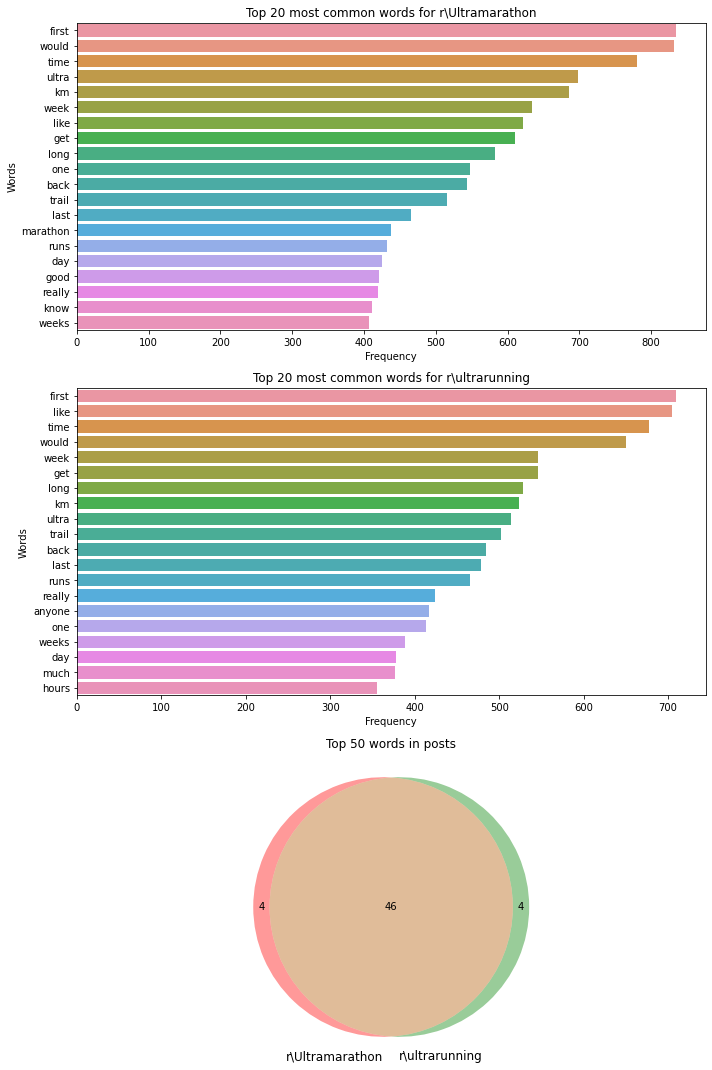

In [86]:
# Recap of common words between subreddits
frequentwords(df, 'cleaned_2', words_to_remove)

Out of the 50 most common words in the two subreddit communities, 46 intersect. Initially, I did not want to remove them as they may be constituents of useful bi-grams and tri-grams. Let's go aggressive and remove all these intersection words to see if it could lead to better predictive models.

#### Create custom function

In [117]:
def intersect_words(data, column_name, number_of_words = 50):
    cvec = CountVectorizer()
    
    # Create word vector on subreddit1 
    vector1 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit1,
            column_name
        ]
    )
    vector1_df = pd.DataFrame(
        vector1.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)

    # Create word vector on subreddit2
    vector2 = cvec.fit_transform(
        data.loc[
            data['subreddit'] == subreddit2,
            column_name
        ]
    )
    vector2_df = pd.DataFrame(
        vector2.todense(),
        columns = cvec.get_feature_names()
    ).sum(
    ).sort_values(
        ascending = False
    ).head(number_of_words)
    

    # Merge both dfs to get a df of intersection words
    unique_words = pd.merge(
        pd.DataFrame(vector1_df),
        pd.DataFrame(vector2_df),
        how='inner', 
        left_on = pd.DataFrame(vector1_df).index, 
        right_on = pd.DataFrame(vector2_df).index)

    return list(unique_words['key_0'].ravel())

#### Obtain intersection of 50 most common words

In [123]:
# Find intersecting words
intersect = intersect_words(df, 'cleaned_lemma', 50)

In [125]:
# Check length to make sure function works
len(intersect)

46

In [126]:
# Review intersecting words
intersect

['week',
 'time',
 'first',
 'would',
 'km',
 'ultra',
 'trail',
 'day',
 'get',
 'year',
 'like',
 'hour',
 'one',
 'long',
 'back',
 'marathon',
 'last',
 'runner',
 'run',
 'know',
 'good',
 'really',
 'distance',
 'much',
 'could',
 'also',
 'ran',
 'anyone',
 'plan',
 'going',
 'go',
 'around',
 'next',
 'want',
 'got',
 'way',
 'miler',
 'feel',
 'lot',
 'thanks',
 'month',
 'think',
 'looking',
 'bit',
 'two',
 'started']

#### Remove intersection words

In [127]:
# Round 3: Expand stop word dictionary
words_to_remove_new = words_to_remove + intersect

In [128]:
words_to_remove_new[-50:]

['race',
 'training',
 'miles',
 'mile',
 'week',
 'time',
 'first',
 'would',
 'km',
 'ultra',
 'trail',
 'day',
 'get',
 'year',
 'like',
 'hour',
 'one',
 'long',
 'back',
 'marathon',
 'last',
 'runner',
 'run',
 'know',
 'good',
 'really',
 'distance',
 'much',
 'could',
 'also',
 'ran',
 'anyone',
 'plan',
 'going',
 'go',
 'around',
 'next',
 'want',
 'got',
 'way',
 'miler',
 'feel',
 'lot',
 'thanks',
 'month',
 'think',
 'looking',
 'bit',
 'two',
 'started']

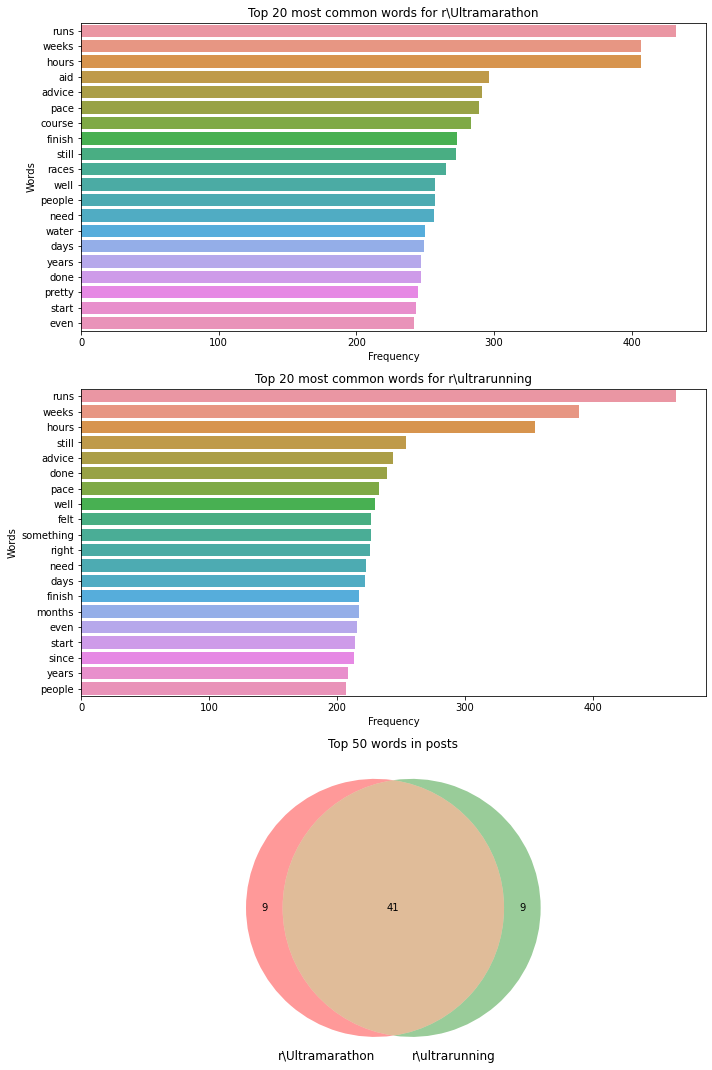

In [129]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove_new)

The result is only marginally better after removing the first 46 most common intersecting words. I still end up with 41 intersecting words. Let's see if this makes Models 2 and 8 better, but I am not hopeful. I am facing a difficult enemy...

#### Create train test set

In [93]:
# Lemmatize after removing more stop words
lemmatizer = WordNetLemmatizer()

df['extreme_cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove_new]
).map(
    lambda x: ' '.join(x)
)

In [94]:
# Create train test sets
X_extreme = df['extreme_cleaned_lemma']
y_extreme = df['target']

X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test = train_test_split(
    X_extreme, y_extreme,
    stratify = y_extreme,
    random_state = 42
)

In [95]:
# Check
X_extreme_train.shape, X_extreme_test.shape, y_extreme_train.shape, y_extreme_test.shape

((2227,), (743,), (2227,), (743,))

#### TfidfVectorizer / Multinomial

In [96]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)

Mean CV score: 0.533
Best Parameters: {'nb__alpha': 0.5, 'tvec__max_df': 0.25, 'tvec__max_features': 2000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.807
Test score (aka Accuracy): 0.557
Sensitivity: 0.547, Specificity: 0.567, Precision: 0.558
CPU times: user 3.5 s, sys: 303 ms, total: 3.81 s
Wall time: 1min 38s


Can't work. Fail...the mean CV score and test score are worse than Model 2's.

#### TfidfVectorizer / RandomForest

In [130]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)

Mean CV score: 0.534
Best Parameters: {'rf__max_depth': 2, 'rf__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train score: 0.708
Test score (aka Accuracy): 0.514
Sensitivity: 0.423, Specificity: 0.605, Precision: 0.516
CPU times: user 2.82 s, sys: 303 ms, total: 3.12 s
Wall time: 2min 44s


#### TfidfVectorizer / ExtraTrees

In [97]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_extreme_train, X_extreme_test, y_extreme_train, y_extreme_test)

Mean CV score: 0.528
Best Parameters: {'et__max_depth': 10, 'et__n_estimators': 100, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.905
Test score (aka Accuracy): 0.549
Sensitivity: 0.555, Specificity: 0.543, Precision: 0.548
CPU times: user 3.33 s, sys: 232 ms, total: 3.57 s
Wall time: 3min 8s


This is a disaster, test score fails baseline score.

#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | Tfidf | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.554 | 0.835 | 0.544 | 0.491 | 0.597 | 0.548 | 3min 4s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.552 | 0.713 | 0.540 | 0.485 | 0.594 | 0.544 | 3min 24s | Lemmatized |
| 7 | Count | ExtraTrees | 0.541 | 0.730 | 0.544 | 0.458 | 0.629 | 0.552 | 3min 5s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.930 | 0.544 | 0.493 | 0.594 | 0.548 | 3min 10s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.558 | 0.671 | 0.550 | 0.543 | 0.558 | 0.552 | 1min 46s | Stemmatized, cousin of Model 2 |
| 10 | Tfidf | RandomForest | 0.562 | 0.885 | 0.545 | 0.594 | 0.496 | 0.542 | 3min 36s | Stemmatized, cousin of Model 6 |
| 11 | Tfidf | ExtraTrees | 0.555 | 0.874 | 0.525 | 0.530 | 0.520 | 0.525 | 3min 24s | Stemmatized, cousin of Model 8 |
|||
| 12 | Tfidf | MultinomialNB | 0.533 | 0.807 | 0.557 | 0.547 | 0.567 | 0.558 | 1min 38s | Lemmatized, remove 46 intersection words |
| 13 | Tfidf | RandomForest | 0.534 | 0.708 | 0.514 | 0.423 | 0.605 | 0.516 | 2min 44s | Lemmatized, remove 46 intersection words |
| 14 | Tfidf | ExtraTrees | 0.528 | 0.905 | 0.549 | 0.555 | 0.543 | 0.548 | 3min 8s | Lemmatized, remove 46 intersection words |

Removing more intersection words does not seem to work. I am running out of options... perhaps the solution is to remove even MORE intersection words. Let's try it out. 

#### Obtain intersection of 200 most common words!!

In [136]:
# Find intersecting words
intersect = intersect_words(df, 'cleaned_lemma', 200)

In [137]:
# Check length to make sure function works
len(intersect)

180

In [138]:
# Review intersecting words
intersect

['week',
 'time',
 'first',
 'would',
 'km',
 'ultra',
 'trail',
 'day',
 'get',
 'year',
 'like',
 'hour',
 'one',
 'long',
 'back',
 'marathon',
 'last',
 'runner',
 'run',
 'know',
 'good',
 'really',
 'distance',
 'much',
 'could',
 'also',
 'ran',
 'anyone',
 'plan',
 'going',
 'go',
 'around',
 'next',
 'want',
 'got',
 'way',
 'miler',
 'feel',
 'lot',
 'thanks',
 'month',
 'aid',
 'think',
 'looking',
 'pace',
 'bit',
 'two',
 'advice',
 'course',
 'started',
 'station',
 'foot',
 'finish',
 'shoe',
 'need',
 'still',
 'start',
 'race',
 'thing',
 'people',
 'take',
 'well',
 'water',
 'done',
 'point',
 'pretty',
 'work',
 'even',
 'felt',
 'thought',
 'minute',
 'road',
 'right',
 'half',
 'help',
 'see',
 'goal',
 'something',
 'since',
 'getting',
 'experience',
 'great',
 'never',
 'new',
 'end',
 'make',
 'keep',
 'couple',
 'guy',
 'little',
 'elevation',
 'sure',
 'able',
 'every',
 'better',
 'event',
 'feeling',
 'question',
 'went',
 'another',
 'enough',
 'best',
 '

#### Remove intersection words

In [139]:
# Round 3: Expand stop word dictionary
words_to_remove_new = words_to_remove + intersect

In [140]:
words_to_remove_new[-50:]

['hill',
 'hr',
 'watch',
 'trying',
 'everyone',
 'love',
 'without',
 'easy',
 'idea',
 'ago',
 'short',
 'try',
 'used',
 'currently',
 'part',
 'maybe',
 'food',
 'post',
 'probably',
 'etc',
 'though',
 'tip',
 'rest',
 'left',
 'hey',
 'may',
 'gain',
 'say',
 'friend',
 'flat',
 'knee',
 'finished',
 'th',
 'might',
 'walking',
 'high',
 'give',
 'else',
 'put',
 'nutrition',
 'starting',
 'break',
 'different',
 'come',
 'pack',
 'slow',
 'found',
 'however',
 'coming',
 'tried']

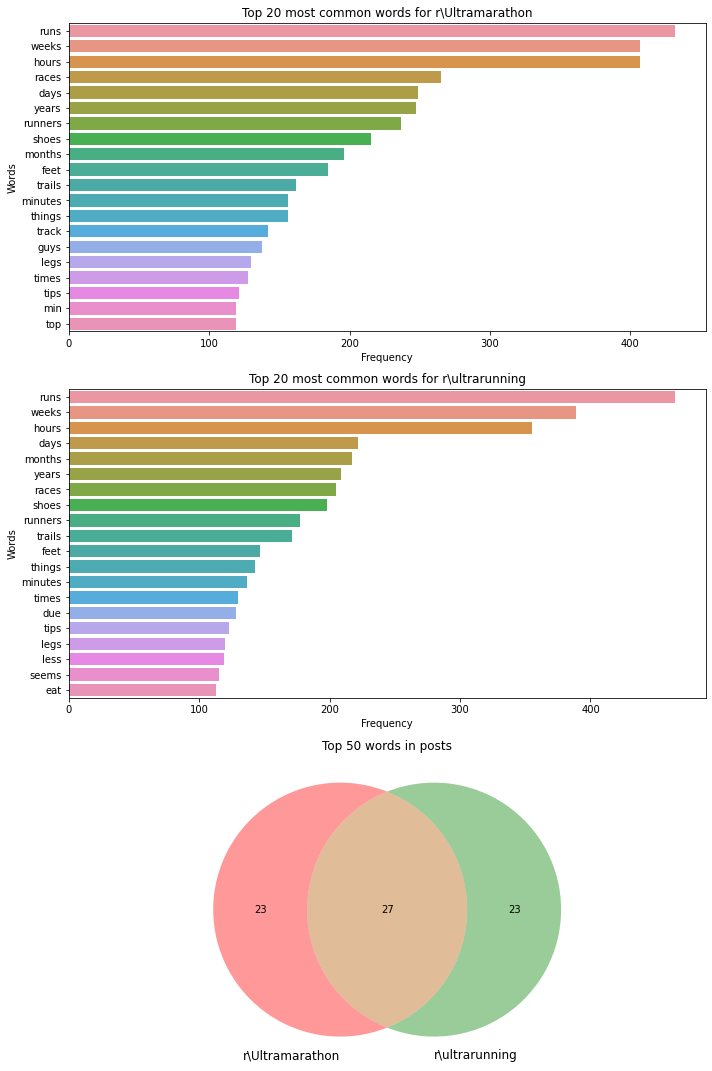

In [141]:
# Check most frequent words after additional stop words 
frequentwords(df, 'cleaned_2', words_to_remove_new)

Out of the top 200 most common words, a staggering 180 words overlap. After removing them, the number of intersecting words in the top 50 drop from 41 to 27. Let's see if this works now.

#### Create train test set

In [142]:
# Lemmatize after removing more stop words
lemmatizer = WordNetLemmatizer()

df['crazy_cleaned_lemma'] = df['cleaned_3'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove_new]
).map(
    lambda x: ' '.join(x)
)

In [143]:
# Create train test sets
X_crazy = df['crazy_cleaned_lemma']
y_crazy = df['target']

X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test = train_test_split(
    X_crazy, y_crazy,
    stratify = y_crazy,
    random_state = 42
)

In [144]:
# Check
X_crazy_train.shape, X_crazy_test.shape, y_crazy_train.shape, y_crazy_test.shape

((2227,), (743,), (2227,), (743,))

#### TfidfVectorizer / Multinomial

In [145]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test)

Mean CV score: 0.529
Best Parameters: {'nb__alpha': 0.25, 'tvec__max_df': 0.1, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.819
Test score (aka Accuracy): 0.575
Sensitivity: 0.550, Specificity: 0.599, Precision: 0.578
CPU times: user 2.36 s, sys: 267 ms, total: 2.62 s
Wall time: 55.9 s


#### TfidfVectorizer / RandomForest

In [146]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test)

Mean CV score: 0.522
Best Parameters: {'rf__max_depth': 8, 'rf__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train score: 0.849
Test score (aka Accuracy): 0.549
Sensitivity: 0.534, Specificity: 0.565, Precision: 0.550
CPU times: user 2.76 s, sys: 178 ms, total: 2.93 s
Wall time: 2min 8s


#### TfidfVectorizer / ExtraTrees

In [147]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_crazy_train, X_crazy_test, y_crazy_train, y_crazy_test)

Mean CV score: 0.523
Best Parameters: {'et__max_depth': 2, 'et__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.708
Test score (aka Accuracy): 0.529
Sensitivity: 0.383, Specificity: 0.675, Precision: 0.540
CPU times: user 3.05 s, sys: 185 ms, total: 3.24 s
Wall time: 2min 3s


#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | Tfidf | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.554 | 0.835 | 0.544 | 0.491 | 0.597 | 0.548 | 3min 4s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.552 | 0.713 | 0.540 | 0.485 | 0.594 | 0.544 | 3min 24s | Lemmatized |
| 7 | Count | ExtraTrees | 0.541 | 0.730 | 0.544 | 0.458 | 0.629 | 0.552 | 3min 5s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.930 | 0.544 | 0.493 | 0.594 | 0.548 | 3min 10s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.558 | 0.671 | 0.550 | 0.543 | 0.558 | 0.552 | 1min 46s | Stemmatized, cousin of Model 2 |
| 10 | Tfidf | RandomForest | 0.562 | 0.885 | 0.545 | 0.594 | 0.496 | 0.542 | 3min 36s | Stemmatized, cousin of Model 6 |
| 11 | Tfidf | ExtraTrees | 0.555 | 0.874 | 0.525 | 0.530 | 0.520 | 0.525 | 3min 24s | Stemmatized, cousin of Model 8 |
|||
| 12 | Tfidf | MultinomialNB | 0.533 | 0.807 | 0.557 | 0.547 | 0.567 | 0.558 | 1min 38s | Lemmatized, remove 46 intersection words |
| 13 | Tfidf | RandomForest | 0.534 | 0.708 | 0.514 | 0.423 | 0.605 | 0.516 | 2min 44s | Lemmatized, remove 46 intersection words |
| 14 | Tfidf | ExtraTrees | 0.528 | 0.905 | 0.549 | 0.555 | 0.543 | 0.548 | 3min 8s | Lemmatized, remove 46 intersection words |
|||
| 15 | Tfidf | MultinomialNB | 0.529 | 0.819 | 0.575 | 0.550 | 0.599 | 0.578 | 55.9 s | Lemmatized, remove 180 intersection words!! |
| 16 | Tfidf | RandomForest | 0.522 | 0.849 | 0.549 | 0.534 | 0.565 | 0.550 | 2min 8s | Lemmatized, remove 180 intersection words!! |
| 17 | Tfidf | ExtraTrees | 0.523 | 0.708 | 0.529 | 0.383 | 0.675 | 0.540 | 2min 3s | Lemmatized, remove 180 intersection words!! |

Removing a lot of common words (180 of them!) has the general effect of lowering the average cross-validation score across all 3 models to approximately 52%. It is getting quite close to our baseline score of 50.1%.
As for test scores, two out of the three models report an improved score, but that might just be random luck, it may not do better for another test set. I am especially suspicious of Model 16 as the deviation between the train and test score is quite high.

Bottom line, I think that removing more common words does not help a situation where two subreddits are quite similar.

### Join Title to Selftext

One final attempt is to try to push beyond the project's remit of analyzing subreddit text only. I shall try to "create" more data by joining a post's title to its text, even though the title typically consists of much fewer words than its text. Perhaps I may be able to push accuracy beyond 0.60...

#### Clean title column

In [148]:
# Remove URLs
df['title_cleaned'] = df['title'].map(
    lambda x: re.sub(r'http\S+', '', x)
)

# Remove the %ampersand term
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: x.replace('&amp;#x200B;', ' ') 
)

# Extract words only    
df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: re.sub('[^a-zA-Z]', ' ', x)
)

# Remove stop words and lemmatize
lemmatizer = WordNetLemmatizer()

df['title_cleaned'] = df['title_cleaned'].map(lambda x: x.lower().split())

df['title_cleaned'] = df['title_cleaned'].map(
    lambda x: [lemmatizer.lemmatize(token) \
               for token in x \
               if token not in words_to_remove
              ]
).map(
    lambda x: ' '.join(x)
)

In [149]:
df[['title', 'title_cleaned']].sample(5)

,title,title_cleaned
189,changing distance and how do i adapt,changing distance adapt
1275,x-post: first 100 miler in 6 months. Looking f...,x post first miler month looking advice
2488,What running Instagram accounts inspire you?,instagram account inspire
1681,Night lights,night light
578,Top layer for 10 to 30 degree running,top layer degree


In [150]:
df['title_cleaned'] + df['cleaned_lemma'], df['title_cleaned'], df['cleaned_lemma']

(0       plan ankle injuryhi long time reader first tim...
 1       report rabbit flat k mountain ultralast week c...
 2       dealing failurehey guy sure belongs technicall...
 3       mcm k salepurchased registration marine corp m...
 4       baseline mpw scheduledone couple ultras want b...
                               ...                        
 2965    witching hour throwback report dani moreno tra...
 2966    snotty forumhi first ever post joined local fo...
 2967    full gps laurel highlandhey anyone full gps fo...
 2968    questionnaire regarding nutrition ultra trailh...
 2969    anyone else struggle carb intakeknow science n...
 Length: 2970, dtype: object,
 0                                       plan ankle injury
 1                     report rabbit flat k mountain ultra
 2                                         dealing failure
 3                                              mcm k sale
 4                                   baseline mpw schedule
                          

#### Create train test split

In [151]:
# Join lemmatized title to lemmatized selftext
#   then create train_test_split

X_joint = df['title_cleaned'] + df['cleaned_lemma']
y_joint = df['target']

X_joint_train, X_joint_test, y_joint_train, y_joint_test = train_test_split(
    X_joint, y_joint,
    stratify = y_joint,
    random_state = 42
)

In [152]:
# Check
X_joint_train.shape, X_joint_test.shape, y_joint_train.shape, y_joint_test.shape

((2227,), (743,), (2227,), (743,))

In [153]:
# Count new number of words

print(f"The original total word count is {df['word_count'].sum()}.")
print(f"Total word count after lemmatization is {np.sum([len(x.split()) for x in df['cleaned_lemma']])}.")
print(f"Total word count after combining title and selftext is {np.sum([len(x.split()) for x in df['title_cleaned'] + df['cleaned_lemma']])}.")

The original total word count is 444679.
Total word count after lemmatization is 205122.
Total word count after combining title and selftext is 214629.


In [154]:
211043 - 203806

7237

I gain another 7237 words to feed into my classification models. Not a lot, but worth something.

#### TfidfVectorizer / Multinomial

In [155]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.1, .25, .5, 1],
    'tvec__max_features' : [500, 1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1]
}

# Run pipe in GridSearchCV and print results
run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)

Mean CV score: 0.542
Best Parameters: {'nb__alpha': 0.25, 'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.806
Test score (aka Accuracy): 0.568
Sensitivity: 0.553, Specificity: 0.583, Precision: 0.569
CPU times: user 2.8 s, sys: 397 ms, total: 3.19 s
Wall time: 1min 50s


#### TfidfVectorizer / RandomForest

In [157]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)

Mean CV score: 0.559
Best Parameters: {'rf__max_depth': 4, 'rf__n_estimators': 150, 'tvec__max_df': 0.5, 'tvec__max_features': 1000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Train score: 0.769
Test score (aka Accuracy): 0.556
Sensitivity: 0.509, Specificity: 0.602, Precision: 0.561
CPU times: user 3.26 s, sys: 281 ms, total: 3.55 s
Wall time: 3min 39s


#### TfidfVectorizer / ExtraTrees

In [160]:
%%time
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

# Set parameters
params = {
    'tvec__min_df': [1],
    'tvec__max_df': [0.5],
    'tvec__max_features' : [500, 1000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'et__n_estimators': [100, 150, 200, 250, 300],
    'et__max_depth' : [None, 2, 4, 6, 8, 10]
}

# Run pipe in GridSearchCV and print results
run_grid(X_joint_train, X_joint_test, y_joint_train, y_joint_test)

Mean CV score: 0.544
Best Parameters: {'et__max_depth': 2, 'et__n_estimators': 300, 'tvec__max_df': 0.5, 'tvec__max_features': 500, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
Train score: 0.706
Test score (aka Accuracy): 0.559
Sensitivity: 0.431, Specificity: 0.685, Precision: 0.578
CPU times: user 3.99 s, sys: 370 ms, total: 4.36 s
Wall time: 3min 18s


This is a disaster, CV score and test score are worse than its cousin Model 8.

#### Update tracking table

| S/N | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Sensitivity (test) | Specificity (test) | Precision (test) | Runtime | Remarks |
|-----|-----------------|------------|------------------|------------------|-----------------|--------------------|---------------------|------------------|---------|---------|
| 1 | Count | MultinomialNB | 0.529 | 0.638 | 0.555 | 0.466 | 0.642 | 0.565 | 1min 38s | Lemmatized |
| 2 | Tfidf | MultinomialNB | 0.542 | 0.793 | 0.559 | 0.569 | 0.548 | 0.557 | 1min 41s | Lemmatized |
| 3 | Count | Logistic | 0.535 | 0.835 | 0.537 | 0.528 | 0.546 | 0.537 | 1min 49s | Lemmatized |
| 4 | Tfidf | Logistic | 0.540 | 0.755 | 0.525 | 0.531 | 0.519 | 0.524 | 1min 36s | Lemmatized |
|||
| 5 | Count | RandomForest | 0.554 | 0.835 | 0.544 | 0.491 | 0.597 | 0.548 | 3min 4s | Lemmatized |
| 6 | Tfidf | RandomForest | 0.552 | 0.713 | 0.540 | 0.485 | 0.594 | 0.544 | 3min 24s | Lemmatized |
| 7 | Count | ExtraTrees | 0.541 | 0.730 | 0.544 | 0.458 | 0.629 | 0.552 | 3min 5s | Lemmatized |
| 8 | Tfidf | ExtraTrees | 0.546 | 0.930 | 0.544 | 0.493 | 0.594 | 0.548 | 3min 10s | Lemmatized |
|||
| 9 | Tfidf | MultinomialNB | 0.558 | 0.671 | 0.550 | 0.543 | 0.558 | 0.552 | 1min 46s | Stemmatized, cousin of Model 2 |
| 10 | Tfidf | RandomForest | 0.562 | 0.885 | 0.545 | 0.594 | 0.496 | 0.542 | 3min 36s | Stemmatized, cousin of Model 6 |
| 11 | Tfidf | ExtraTrees | 0.555 | 0.874 | 0.525 | 0.530 | 0.520 | 0.525 | 3min 24s | Stemmatized, cousin of Model 8 |
|||
| 12 | Tfidf | MultinomialNB | 0.533 | 0.807 | 0.557 | 0.547 | 0.567 | 0.558 | 1min 38s | Lemmatized, remove 46 intersection words |
| 13 | Tfidf | RandomForest | 0.534 | 0.708 | 0.514 | 0.423 | 0.605 | 0.516 | 2min 44s | Lemmatized, remove 46 intersection words |
| 14 | Tfidf | ExtraTrees | 0.528 | 0.905 | 0.549 | 0.555 | 0.543 | 0.548 | 3min 8s | Lemmatized, remove 46 intersection words |
|||
| 15 | Tfidf | MultinomialNB | 0.529 | 0.819 | 0.575 | 0.550 | 0.599 | 0.578 | 55.9 s | Lemmatized, remove 180 intersection words!! |
| 16 | Tfidf | RandomForest | 0.522 | 0.849 | 0.549 | 0.534 | 0.565 | 0.550 | 2min 8s | Lemmatized, remove 180 intersection words!! |
| 17 | Tfidf | ExtraTrees | 0.523 | 0.708 | 0.529 | 0.383 | 0.675 | 0.540 | 2min 3s | Lemmatized, remove 180 intersection words!! |
|||
| 18 | Tfidf | MultinomialNB | 0.542 | 0.806 | 0.568 | 0.553 | 0.583 | 0.569 | 1min 50s | Lemmatized, title + selftext, cousin of Model 2 |
| 19 | Tfidf | RandomForest | 0.559 | 0.769 | 0.556 | 0.509 | 0.602 | 0.561 | 3min 39s | Lemmatized, title + selftext, cousin of Model 6 |
| 20 | Tfidf | ExtraTrees | 0.544 | 0.706 | 0.559 | 0.431 | 0.685 | 0.578 | 3min 18s | Lemmatized, title + selftext, cousin of Model 8 |

## Tuning hyperparameters

## Conclusion

I tried my best but it is extremely hard to squeeze out more performance from standard classification models to predict a post's likelihood of being in r\Ultramarathon or r\ultrarunning. To recap, I tried a total of 14 models (16, if you include my ill-fated attempt to limit word vectorizers to bigrams and trigrams only), but I am unable to raise test accuracy to go beyond **55%**. The baseline score is **50.1%**. 

The "best" overall model is to use lemmatization + Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer + a multinomial naive Bayes classifier trained on post content. I tried a couple of variations, namely using stem words, removal of words with high level of intersection between sets of common words in r\Ultramarathon and r\ultrarunning, and even a desperate attempt to combine words in the title to the post's content.  Unfortunately, these attempts were unable to induce a material improvement in predictive ability.

My conclusion is that I have inadvertently picked two extremely similar subreddits to tackle. Perhaps, as author 05778 wrote in one of his posts (see below), **"Why Not Kill This Subreddit?	And merge it with r/ultrarunning?**. I have no choice but to agree with him wholeheartedly!

In [107]:
df.loc[df['author'] == '05778', ['subreddit','author','title','cleaned_1']]

,subreddit,author,title,cleaned_1
57,Ultramarathon,05778,UTMB 2022 Dates,Does anybody know the the dates for UTMB in 20...
664,Ultramarathon,05778,Poles on an Airplane?,Had anyone ever taken their trekking/running p...
964,Ultramarathon,05778,Why Not Kill This Subreddit?,And merge it with r/ultrarunning?
1633,ultrarunning,05778,Maybe The Top American Men Should Just Finish ...,Instead of quitting as soon as the chance of w...
2918,ultrarunning,05778,UTMB Points 2021,With so few races in 2020 will UTMB alter thei...
